# Imports and setup

In [1]:
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher as cmr

%matplotlib inline
import numpy as np
import gala.coordinates as gc

from jax.config import config

config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jaxopt

import pickle

import arviz as az
import numpyro

from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

numpyro.enable_x64()
numpyro.set_host_device_count(2)
#from numpyro_ext.optim import optimize

import sys
import importlib
sys.path.append('/Users/Tavangar/Work/stream-membership/')
sys.path.append('../../')
sys.path.append('/Users/Tavangar/Work/CATS_workshop/cats/')
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
)
from gd1_helpers.membership.initialize import *
from scripts.gd1_init import *

from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

In [2]:
cmap = plt.get_cmap('cmr.amber_r')
mpl.rc('image', cmap=cmap.name)
mpl.rc('image', cmap='gray_r')

In [3]:
data = at.Table.read("../../../CATS_Workshop/cats/data/joined-GD-1.fits")

#data = at.Table.read('../data/tmp/run_data.fits')
#masks = at.Table.read('../data/tmp/run_data_masks.fits')
cat = data
cat['pm1'] = cat['pm_phi1_cosphi2_unrefl']
cat['pm2'] = cat['pm_phi2_unrefl']


stream='GD-1'
phi1_lim = (np.min(cat['phi1']), np.max(cat['phi1']))
phi1_lim = [-100,20]

cat = cat[(cat['phi1'] < phi1_lim[1]) & (cat['phi1'] > phi1_lim[0])] # clunky to hard code this

In [4]:
p = Pawprint.pawprint_from_galstreams(inputs[stream]['short_name'],
                                      inputs[stream]['pawprint_id'],
                                      width=inputs[stream]['width'] * u.deg,
                                      phi1_lim=phi1_lim)

# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)

# Create the CMD cuts
o = Isochrone(stream, cat, pawprint=p)
_, iso_mask, _, hb_mask, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

pmsel = ProperMotionSelection(stream, cat, pprint,
                              n_dispersion_phi1=3, n_dispersion_phi2=3, cutoff=0.1)

##### rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)

Modifying/extrapolating galstreams track
Modifying/extrapolating galstreams track
-40.18182128833206
Fitting for peak pm location
Pre-fitting mean PM values: -13.031, -3.108
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [-13.2765824411502, -3.1631661457594973, 0.4018776191208751, 0.5346353001205577] 

Producing the polygon and mask


In [5]:
# with open('../data/gd1_pawprint.pkl', 'wb') as output_file:
#     pickle.dump(p, output_file)

In [5]:
run_data_ = o.cat[pm_mask & (iso_mask | hb_mask)]
run_data = {k: np.array(run_data_[k], dtype="f8") for k in run_data_.colnames}

# with open('../data/gd1_run_data.pkl', 'wb') as output_file:
#     pickle.dump(run_data, output_file)

bkg_data_ = o.cat[pm_mask & (iso_mask | hb_mask) & ~o.on_skymask]
bkg_data = {k: np.array(bkg_data_[k], dtype="f8") for k in bkg_data_.colnames}

# with open('../data/gd1_bkg_data.pkl', 'wb') as output_file:
#     pickle.dump(bkg_data, output_file)

stream_data_ = o.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & o.on_skymask]
stream_data = {k: np.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

# with open('../data/gd1_stream_data.pkl', 'wb') as output_file:
#     pickle.dump(stream_data, output_file)

In [7]:
patch_sky = mpl.patches.Polygon(
            o.pawprint.skyprint["stream"].vertices[::50],
            facecolor="r",
            edgecolor="r",
            linewidth=1,
            alpha=0.2
        )

spline_phi2, spline_pm1, spline_pm2, _ = pmsel.from_galstreams()

fig, axes, _ = plot_data_projections(data=run_data, grids=Base.default_grids,
                      smooth=1, pcolormesh_kwargs={'rasterized':True});
axes[0].add_patch(patch_sky)
phi1_array = np.arange(-100, 20, 0.2)
axes[1].fill_between(phi1_array, spline_pm1(phi1_array)+np.exp(-0.5), spline_pm1(phi1_array)-np.exp(-0.5), 
                     color='r', alpha=0.2)
axes[2].fill_between(phi1_array, spline_pm2(phi1_array)+np.exp(-0.5), spline_pm2(phi1_array)-np.exp(-0.5), 
                     color='r', alpha=0.2)
# axes[1].add_patch(patch_pm1)
# axes[2].add_patch(patch_pm2)
# plt.savefig('../paper_figures/gd1_data.pdf')
plt.show()

AttributeError: type object 'Base' has no attribute 'default_grids'

# Background

In [6]:
import importlib
importlib.reload(sys.modules['scripts.gd1_init'])

from scripts.gd1_init import *

In [7]:
BkgModel = make_bkg_model(BackgroundModel, p, cat, knot_sep=10, phi2_bkg=False)

In [8]:
bkg_init_p = {
    "ln_N": np.log(len(bkg_data['phi1'])),
    #"phi1": {'zs': np.array([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])+1},
    "phi1": {'zs': np.zeros(BkgModel.phi1_locs.shape[0]-1)},
    "phi2": {},
    "pm1": {
        "w": np.full_like(BkgModel.pm1_knots, 0.5),
        "mean1": np.full_like(BkgModel.pm1_knots, 0),
        "ln_std1": np.full_like(BkgModel.pm1_knots, 1),
        "mean2": np.full_like(BkgModel.pm1_knots, 5),
        "ln_std2": np.full_like(BkgModel.pm1_knots, 2)
    },
    "pm2": {
        "w": np.full_like(BkgModel.pm2_knots, 0.5),
        "mean1": np.full_like(BkgModel.pm2_knots, -2.),
        "ln_std1": np.full_like(BkgModel.pm2_knots, 1),
        "mean2": np.full_like(BkgModel.pm2_knots, -3),
        "ln_std2": np.full_like(BkgModel.pm2_knots, 2)
    },
}

In [9]:
background_init = BkgModel(bkg_init_p)

In [11]:
def optimize(cls, data, init_params, jaxopt_kwargs=None, use_bounds=True, **kwargs):
    """
    A wrapper around numpyro_ext.optim utilities, which enable jaxopt optimization
    for numpyro models.
    """
    import jaxopt

    if jaxopt_kwargs is None:
        jaxopt_kwargs = {}
    jaxopt_kwargs.setdefault("maxiter", 1024)  # TODO: TOTALLY ARBITRARY

    optimize_kwargs = kwargs
    #jaxopt_kwargs.setdefault("method", "L-BFGS-B")
    optimize_kwargs["bounds"] = cls._get_jaxopt_bounds()
    optimize_kwargs["bounds"] = (
        cls._normalize_variable_keys(optimize_kwargs["bounds"][0]),
        cls._normalize_variable_keys(optimize_kwargs["bounds"][1]),
    )
    Optimizer = jaxopt.LBFGSB

    optimizer = Optimizer(**jaxopt_kwargs, fun=cls._objective)
    opt_res = optimizer.run(
        init_params=cls._normalize_variable_keys(init_params),
        data=cls._normalize_variable_keys(data),
        **optimize_kwargs,
    )
    return cls._expand_variable_keys(opt_res.params), opt_res.state

In [12]:
bkg_opt_pars, bkg_info = background_init.optimize(
    data=bkg_data,
    init_params=bkg_init_p,
    use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096),
)

# bkg_opt_pars, bkg_info = optimize(BackgroundModel,
#     data=bkg_data,
#     init_params=bkg_init_p,
#     use_bounds=True,
#     jaxopt_kwargs=dict(maxiter=4096),
# )

background_opt = BkgModel(bkg_opt_pars)
bkg_info

ScipyMinimizeInfo(fun_val=Array(0.70693482, dtype=float64, weak_type=True), success=True, status=0, iter_num=1314, hess_inv=LbfgsInvHessProduct(sk=[[-5.25833120e-05  6.91926668e-04 -5.19993266e-04 ...  4.79601844e-04
  -2.50973097e-04 -7.96021835e-04]
 [ 6.53157197e-05  1.20362403e-03 -7.32628869e-04 ...  1.41036199e-03
  -1.85929977e-04 -1.47949310e-03]
 [-2.44342546e-05 -1.57460604e-04  1.10515381e-04 ... -1.09078976e-04
   3.44338752e-04 -4.92950564e-04]
 ...
 [ 5.80544631e-05  5.27777078e-04 -2.75265326e-04 ...  1.33704675e-03
  -3.35300246e-04  1.14209645e-04]
 [-5.87304460e-06  3.61528145e-04 -2.83213685e-04 ...  1.92950760e-04
  -3.62924050e-04  1.97787287e-04]
 [-1.77757378e-05  5.48348336e-04 -4.11952937e-04 ...  9.90665865e-05
  -4.71760835e-04 -1.77512939e-04]], yk=[[-5.25821688e-05 -1.29661724e-06 -1.82869798e-06 ... -1.24773877e-05
  -4.76608948e-06 -5.18886581e-06]
 [ 6.53147154e-05 -1.41201225e-06 -2.06587676e-06 ... -9.60661292e-06
   2.70681517e-06 -6.54489729e-06]
 [-

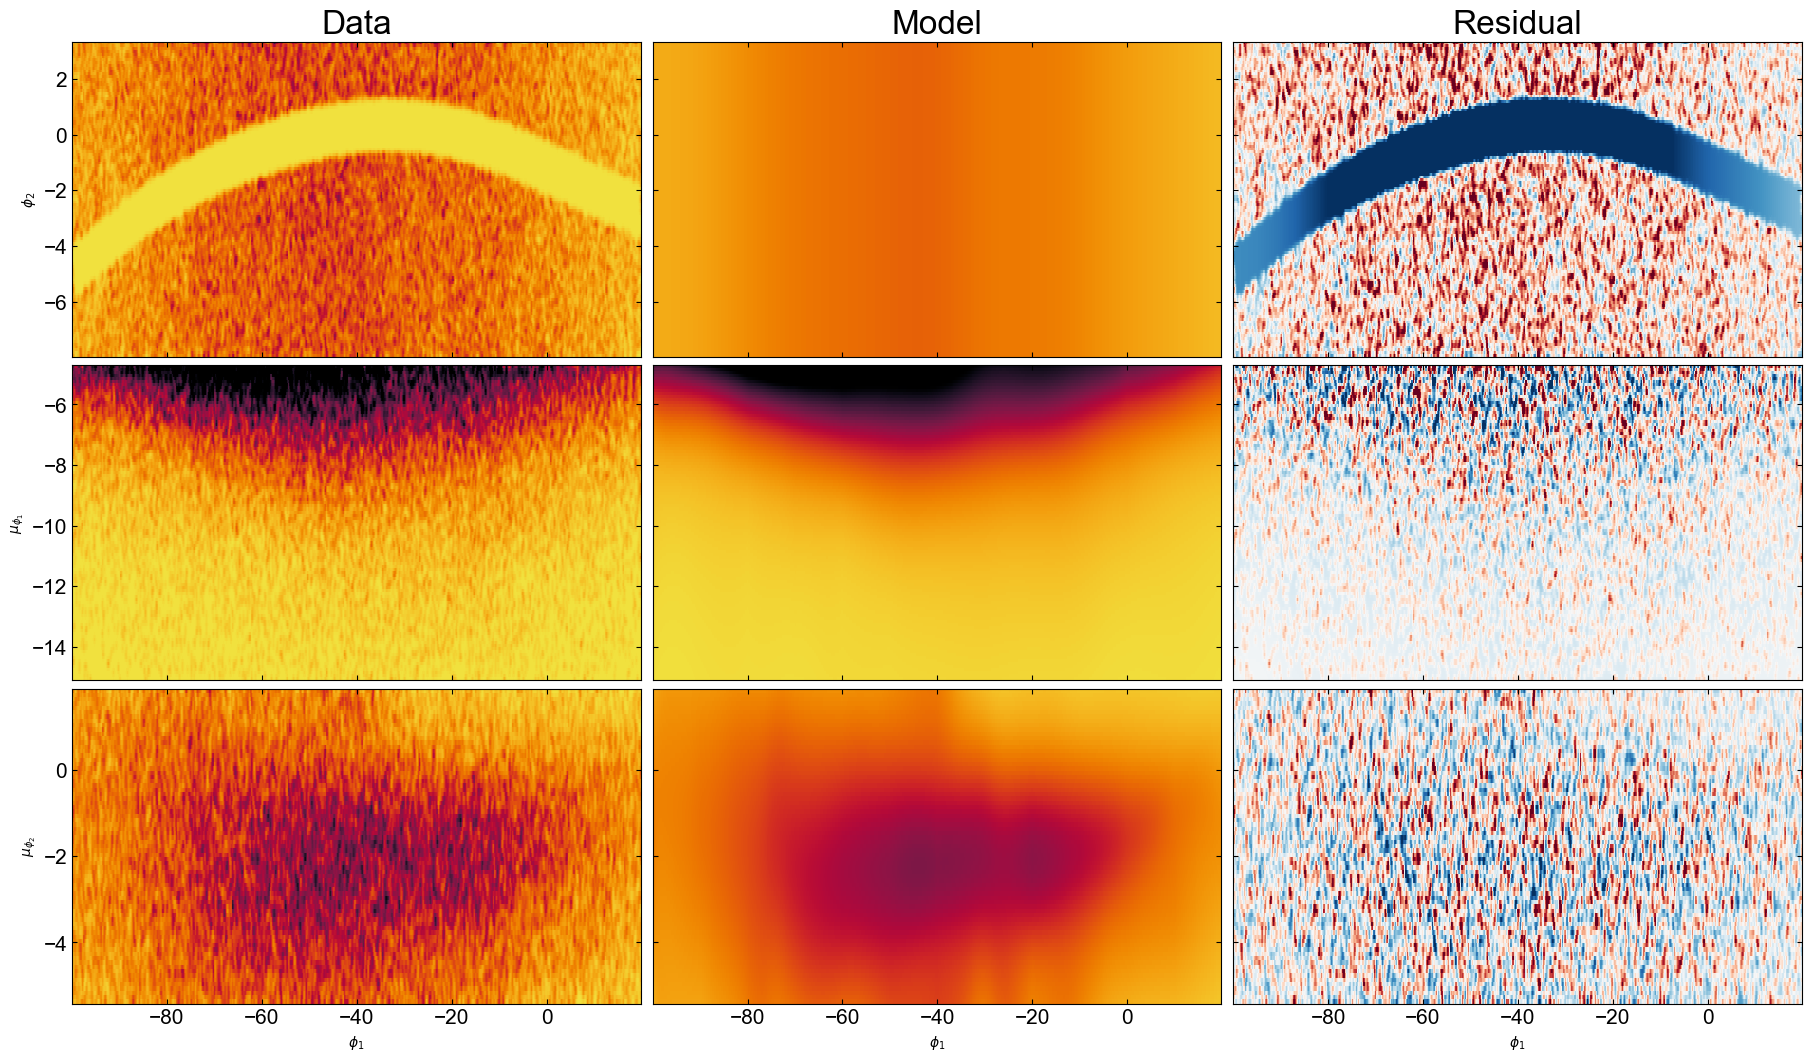

In [13]:
import importlib
importlib.reload(sys.modules['stream_membership.plot'])
importlib.reload(sys.modules['stream_membership.model'])

fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=BackgroundModel.default_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0)
    # coord_names=GD1BackgroundModel.coord_names,
)
background_opt.plot_model_projections(axes=axes[:, 1], label=False,
                                     pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0))
background_opt.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True)
)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.show()
# fig.savefig('../../paper_figures/background_model.pdf')

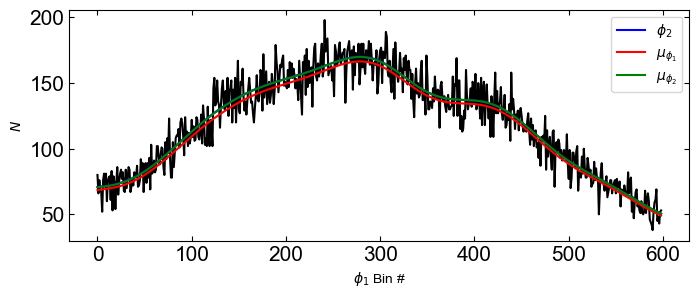

In [14]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_opt.default_grids["phi1"], background_opt.default_grids['phi2'])
)

grids, ln_ns = background_opt.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_2}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

# Stream

In [15]:
StrModel = make_stream_model(StreamDensModel, p, cat, knot_sep=10)

In [16]:
# TODO: replace this with galstreams initialization
from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline

#stream_mask = masks["sky_track"] & masks["pm_rough"]
stream_data_ = o.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & o.on_skymask]
#stream_data = {k: v[stream_mask] for k, v in stream_data_.items()}
stream_data = {k: np.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

_phi2_stat = binned_statistic(stream_data["phi1"], stream_data["phi2"], bins=np.linspace(phi1_lim[0], phi1_lim[1], 21))
_phi2_interp = IUS(
    0.5 * (_phi2_stat.bin_edges[:-1] + _phi2_stat.bin_edges[1:]), _phi2_stat.statistic, ext=0, k=1
)

_pm1_stat = binned_statistic(stream_data["phi1"], stream_data["pm1"], bins=np.linspace(phi1_lim[0], phi1_lim[1], 32))
_pm1_interp = IUS(
    0.5 * (_pm1_stat.bin_edges[:-1] + _pm1_stat.bin_edges[1:]), _pm1_stat.statistic, ext=0, k=1
)

_pm2_stat = binned_statistic(stream_data["phi1"], stream_data["pm2"], bins=np.linspace(phi1_lim[0], phi1_lim[1], 32))
_pm2_interp = IUS(
    0.5 * (_pm2_stat.bin_edges[:-1] + _pm2_stat.bin_edges[1:]), _pm2_stat.statistic, ext=0, k=1
)

In [20]:
stream_opt_pars, info = stream_init.optimize(
    data=stream_data, init_params=stream_init_p, use_bounds=True, jaxopt_kwargs=dict(maxiter=4096),
)

# stream_opt_pars, info = optimize(StreamDensModel,
#     data=stream_data, init_params=stream_init_p, use_bounds=True
# )

stream_opt = StrModel(stream_opt_pars)
info

ScipyMinimizeInfo(fun_val=Array(-0.59354714, dtype=float64, weak_type=True), success=True, status=0, iter_num=1201, hess_inv=LbfgsInvHessProduct(sk=[[ 8.88178420e-16 -4.40916909e-04  1.62229262e-04 ... -2.93259050e-07
   3.37134855e-05  2.39232381e-05]
 [ 8.88178420e-16 -2.87908844e-04  8.82455117e-05 ... -3.24609626e-07
   3.32536469e-05  1.06811132e-05]
 [ 8.88178420e-16 -3.37013234e-04  1.28602729e-04 ... -2.82910225e-07
   3.97800251e-05  1.66580886e-05]
 ...
 [ 7.10542736e-15 -7.02248346e-04  3.12075485e-04 ...  1.19327813e-06
  -6.01405064e-05  1.82289887e-05]
 [ 1.77635684e-15 -4.61650453e-05 -4.04434305e-06 ...  3.13478896e-08
  -1.49064981e-05 -9.34899057e-06]
 [-7.10542736e-15 -3.68628876e-04  1.11317362e-04 ... -5.85904784e-07
  -3.36581479e-05 -1.34234995e-05]], yk=[[ 8.88178420e-16  8.26567494e-08  4.65821464e-07 ... -1.69760199e-07
   3.40021864e-06  3.95026412e-07]
 [ 8.88178420e-16  2.11834787e-08  1.69899714e-07 ... -1.93188867e-07
   3.32334389e-06  2.81295175e-07]
 [

Text(0, 0.5, '$\\phi_2$')

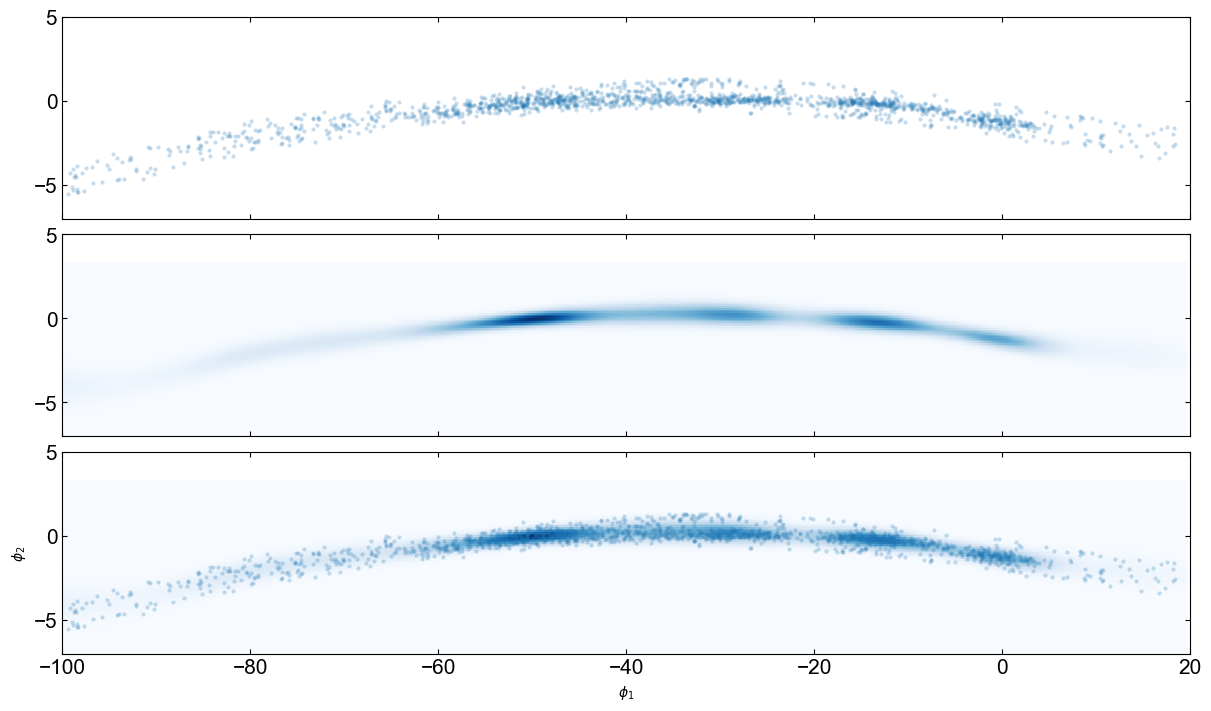

In [21]:
_grids, ln_dens = stream_opt.evaluate_on_2d_grids()

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)

for ax in [axes[0], axes[2]]:
    ax.plot(
        stream_data['phi1'],
        stream_data['phi2'],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

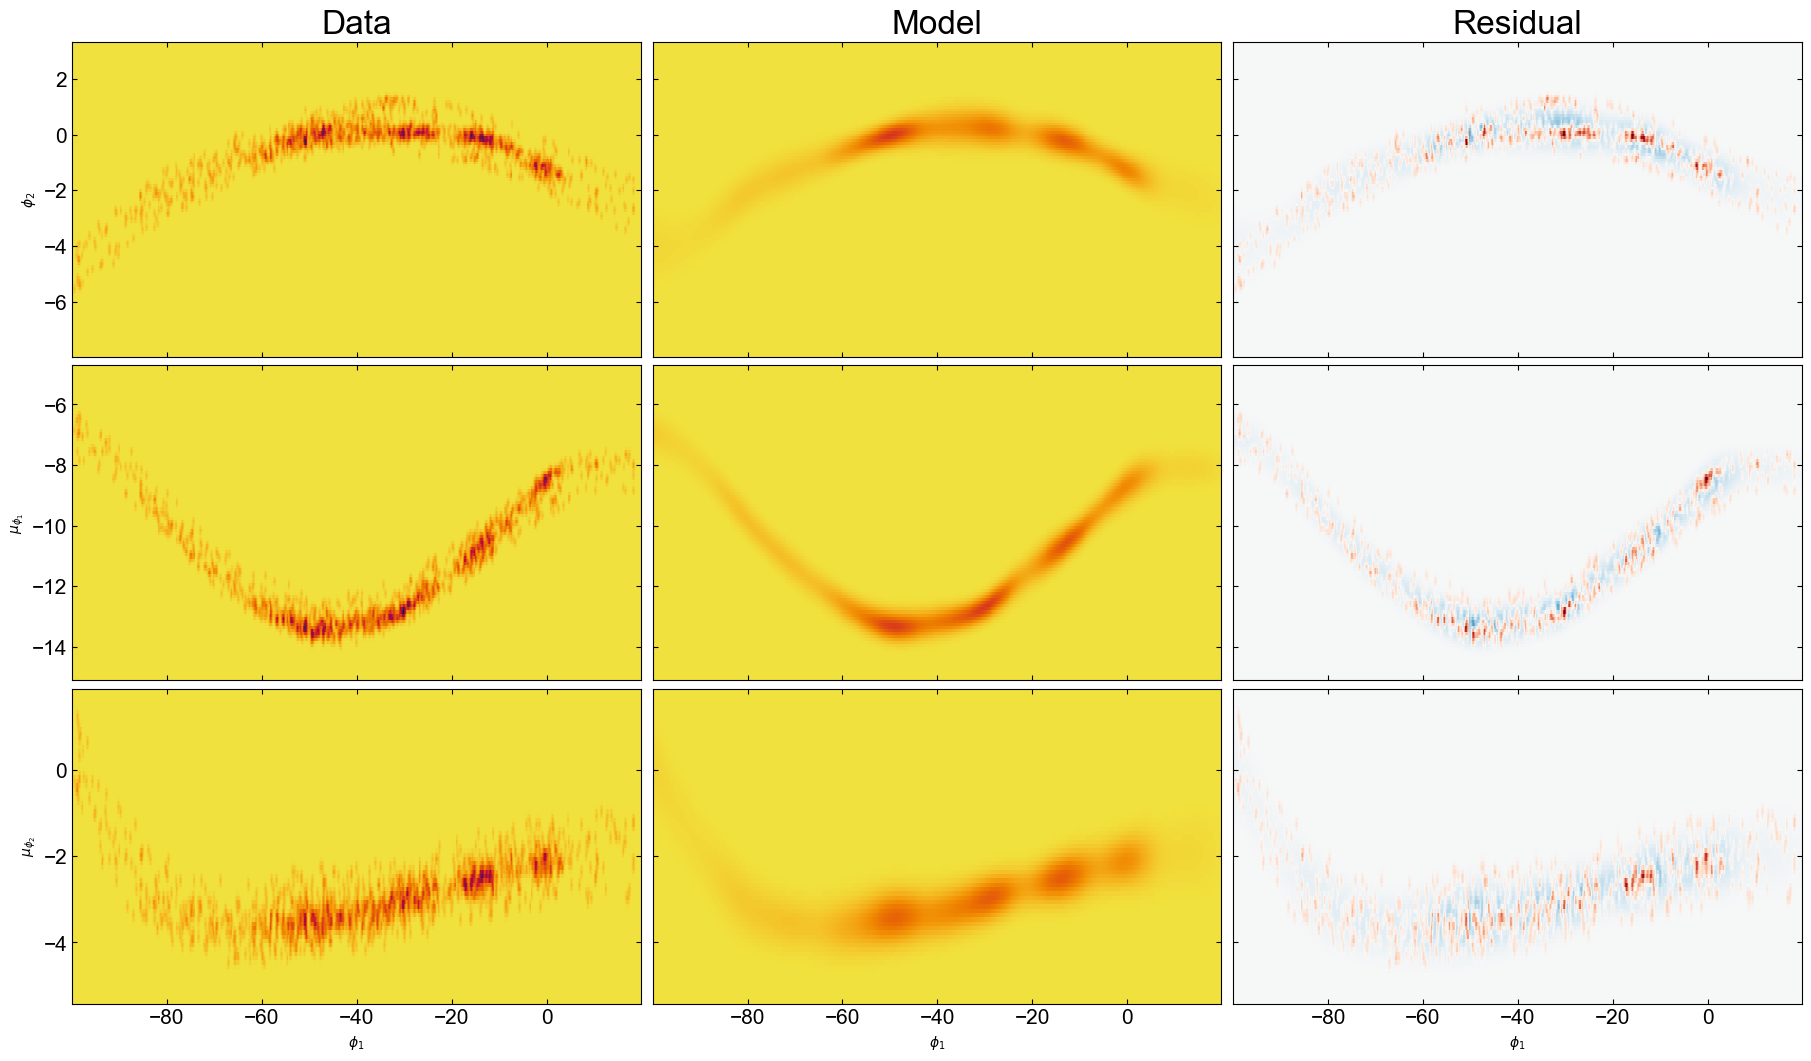

In [22]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=stream_data,
    grids=stream_opt.default_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmin=0, vmax=2)
)
stream_opt.plot_model_projections(axes=axes[:, 1], label=False, 
                                  pcolormesh_kwargs=dict(rasterized=True,vmin=0, vmax=2))
stream_opt.plot_residual_projections(
    data=stream_data, axes=axes[:, 2], label=False,
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True)
)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.show()
# fig.savefig('../paper_figures/stream_model.pdf')

# Mixture of Stream + Background (no off-track)

In [23]:
Components = [StrModel, BkgModel]
mix_params0 = {"stream": stream_opt_pars, "background": bkg_opt_pars}
mix_params0['background']['ln_N'] = np.log(len(run_data['phi1']) - np.exp(mix_params0['stream']['ln_N']))

In [24]:
mix_init = StreamMixtureModel(mix_params0, Components)

In [43]:
from functools import partial

def optimize_mixture(cls, data, init_params, Components, jaxopt_kwargs=None, use_bounds=True, **kwargs):
    """
    A wrapper around numpyro_ext.optim utilities, which enable jaxopt optimization
    for numpyro models.
    """
    import jaxopt

    if jaxopt_kwargs is None:
        jaxopt_kwargs = {}
    jaxopt_kwargs.setdefault("maxiter", 1024)  # TODO: TOTALLY ARBITRARY

    tied_params = kwargs.pop('tied_params', None)
    
    optimize_kwargs = kwargs
    #jaxopt_kwargs.setdefault("method", "L-BFGS-B")
    optimize_kwargs["bounds"] = cls._get_jaxopt_bounds(Components, tied_params)
    # optimize_kwargs["bounds"] = (
    #     cls._normalize_variable_keys(optimize_kwargs["bounds"][0]),
    #     cls._normalize_variable_keys(optimize_kwargs["bounds"][1]),
    # )
    Optimizer = jaxopt.LBFGSB

    optimizer = Optimizer(**jaxopt_kwargs, fun=partial(cls._objective, 
                                                      Components=Components,
                                                      tied_params=tied_params))
    opt_res = optimizer.run(
        init_params={C.name: C._normalize_variable_keys(init_params[C.name])
                     for C in Components},
        data=Components[0]._normalize_variable_keys(data),
        **optimize_kwargs,
    )
    opt_p = {
            C.name: C._expand_variable_keys(opt_res.params[C.name]) for C in Components
        }
    return opt_p, opt_res.state

There needs to be a way to run the optimization with your choice of optimizer (e.g. ScipyBoundedMinimize vs LBFGSB vs Nelder-Mead ...)

In [26]:
mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data, Components=Components, init_params=mix_params0, use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096)
)

# mix_opt_pars, info = optimize_mixture(StreamMixtureModel, data=run_data,
#                                       init_params=mix_params0, Components=Components,
#                                       use_bounds=True)

mix_opt = StreamMixtureModel(mix_opt_pars, Components=Components)
info

ScipyMinimizeInfo(fun_val=Array(0.48794636, dtype=float64, weak_type=True), success=True, status=0, iter_num=750, hess_inv=LbfgsInvHessProduct(sk=[[-7.01032278e-05 -4.62856050e-04 -3.93036014e-06 ... -2.45823522e-05
   3.28961511e-05  1.36547634e-04]
 [ 5.02276277e-05 -3.97529472e-04  1.85079646e-04 ...  6.01086281e-05
  -5.65246607e-05  3.05627703e-04]
 [-1.88623953e-04 -5.55494102e-04  1.46621606e-04 ...  7.94590969e-05
  -4.28855979e-05  2.97617797e-04]
 ...
 [-1.03603567e-04 -2.86923230e-04  6.47130007e-05 ... -7.85545620e-06
  -4.94700139e-08 -2.33969634e-05]
 [-2.17544039e-06 -6.94021401e-04  1.46287723e-04 ...  1.83705683e-05
  -3.03119833e-05 -2.88995413e-05]
 [-3.75844107e-05 -3.46714835e-03  6.48943541e-04 ... -3.87130703e-05
   1.08466857e-04  1.69927257e-03]], yk=[[-6.76897138e-05 -2.40693110e-07 -1.07497633e-06 ... -3.43183786e-07
   1.59342178e-07  4.26769260e-08]
 [ 4.95414184e-05 -4.61187084e-08 -3.94912545e-07 ...  7.30050525e-07
  -2.28719839e-07  3.75379080e-08]
 [-1

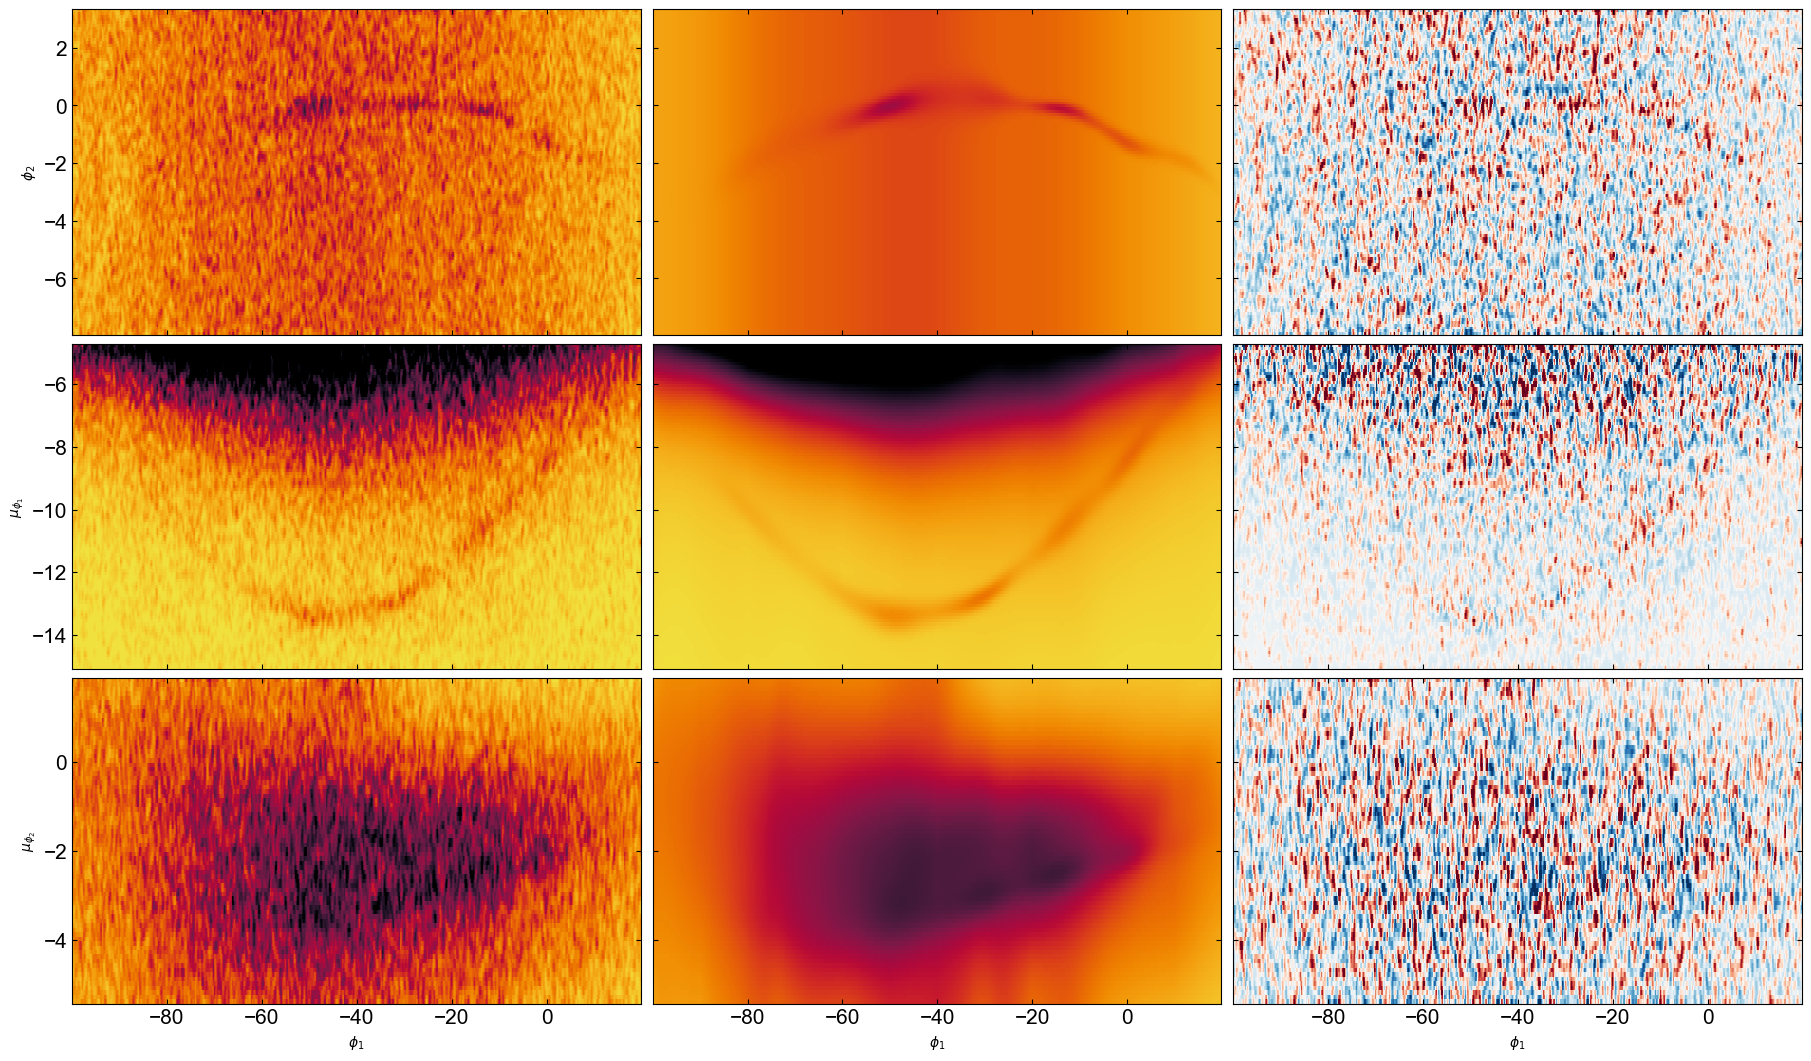

In [27]:
fig, axes = plt.subplots(
    len(mix_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(mix_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=mix_opt.default_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmin=0, vmax=5)
)
mix_opt.plot_model_projections(axes=axes[:, 1], label=False,
                              pcolormesh_kwargs=dict(rasterized=True, vmin=0, vmax=5))
mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], label=False,
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu')
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

In [46]:
with open('../data/mix_opt_params.pkl', 'wb') as output:
    pickle.dump(mix_opt_pars, output)

In [44]:
stream_comp, bkg_comp = mix_opt.components[0], mix_opt.components[1]
stream_ll = -np.log(stream_comp.get_N()) + stream_comp.ln_number_density(run_data)
bkg_ll = -np.log(bkg_comp.get_N()) + bkg_comp.ln_number_density(run_data)
print(stream_ll.sum(), bkg_ll.sum())

-inf -977767.6940153923


I think what I've done here is show that there is a typo in stream-membership. I think that in the ln-Likelihood function, it should be np.log(N) instead of just N (or the equivalent, since the syntax is slightly different in different functions).

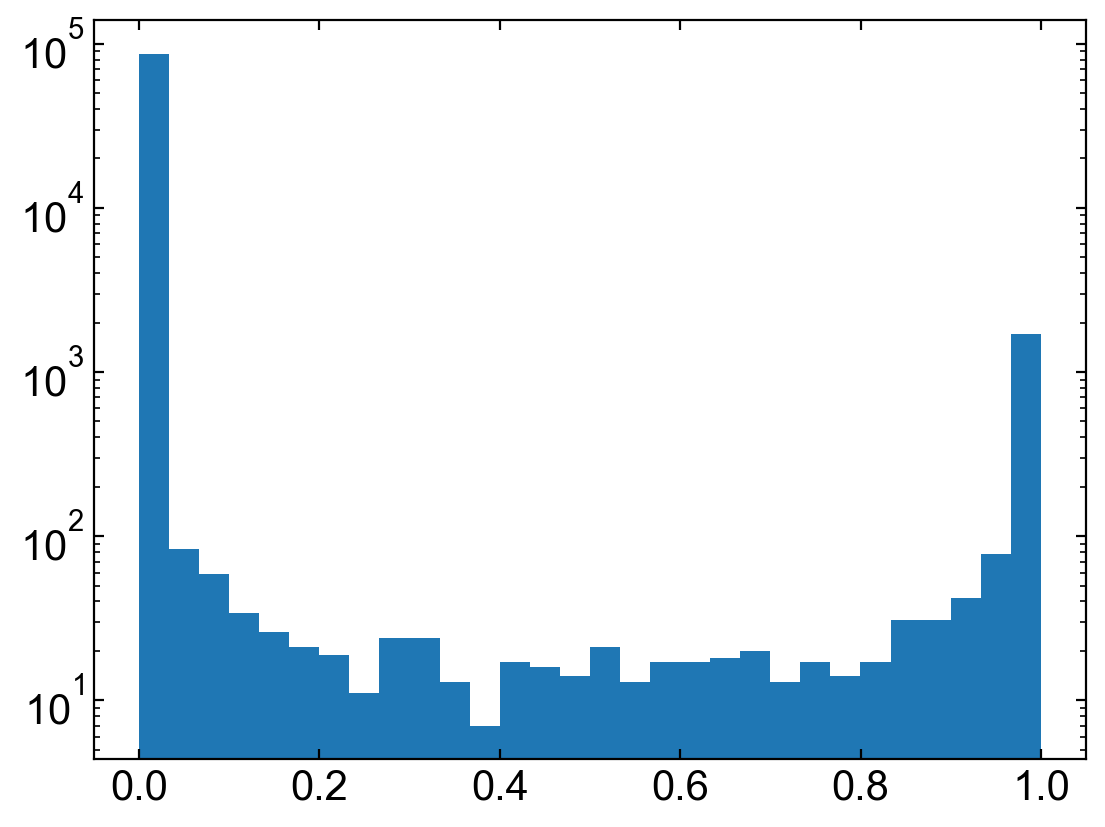

In [46]:
memb_prob = np.exp(stream_ll - np.logaddexp(stream_ll,bkg_ll))
plt.hist(memb_prob, bins=30)
plt.yscale('log')

In [47]:
(memb_prob > 0.5).sum()

2062

Text(0, 0.5, '$\\phi_2$')

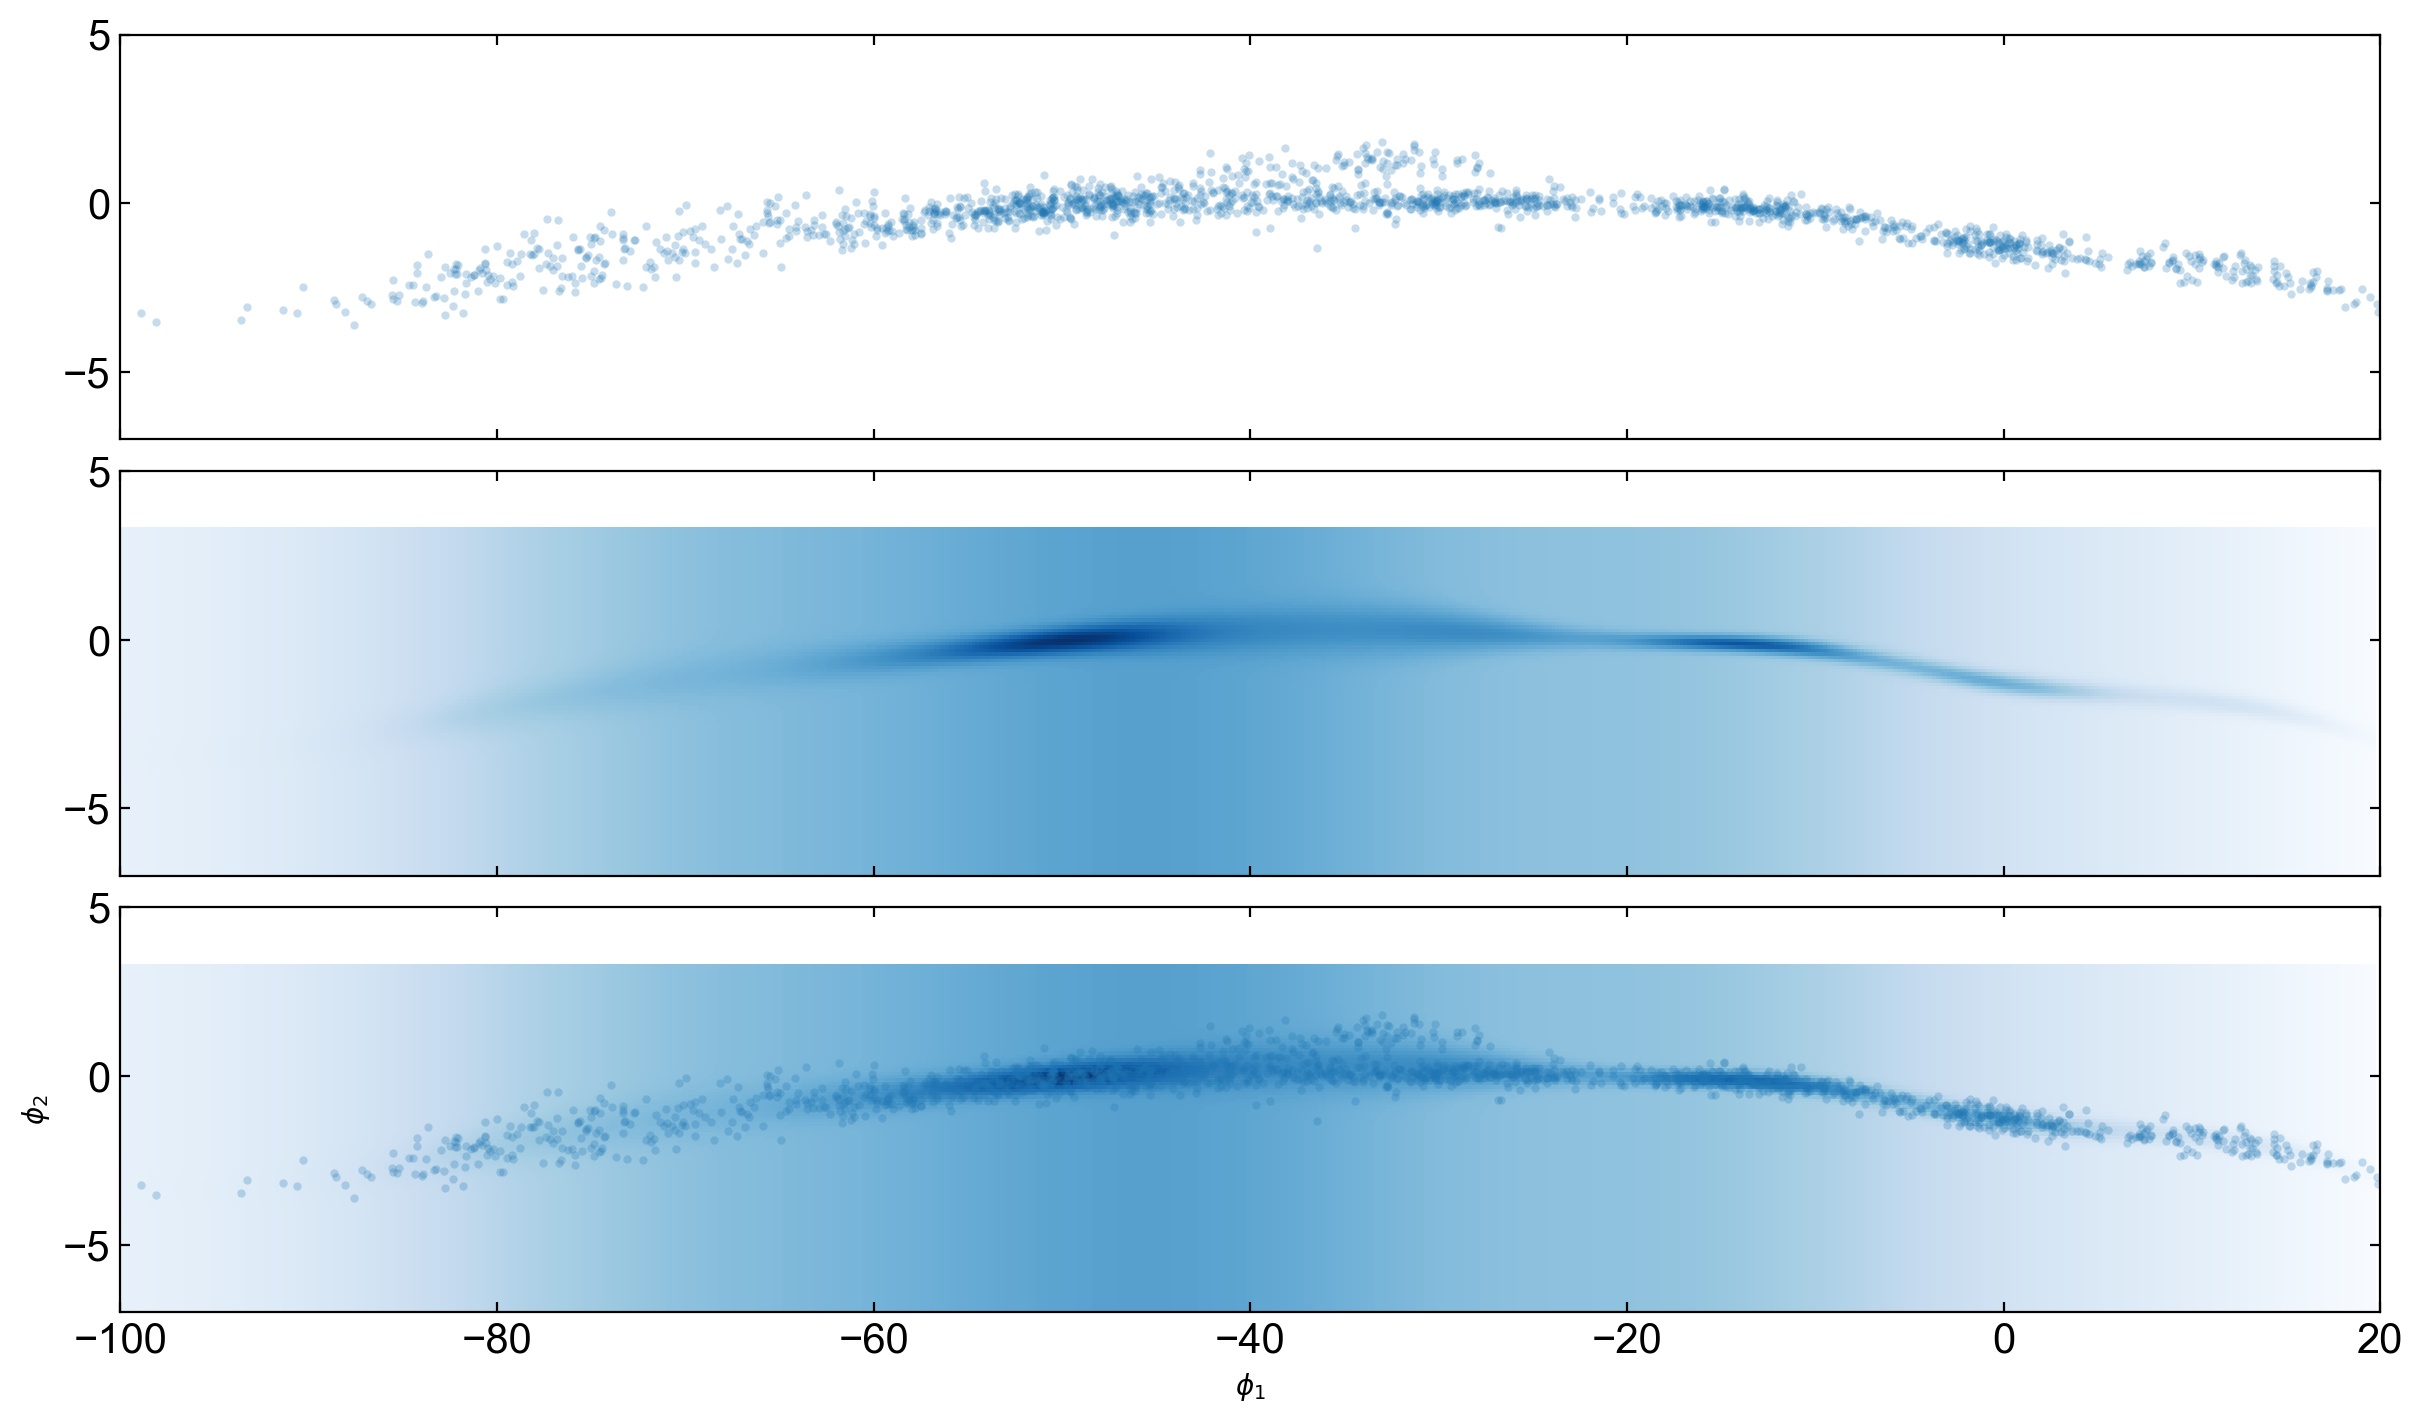

In [48]:
_grids, ln_dens = mix_opt.evaluate_on_2d_grids()

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)
for ax in [axes[0], axes[2]]:
    ax.plot(
        run_data['phi1'][memb_prob>0.9],
        run_data['phi2'][memb_prob>0.9],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

# Off-track

In [51]:
import importlib
importlib.reload(sys.modules['scripts.gd1_init'])

from scripts.gd1_init import *

In [199]:
OffTrackModel.offtrack_update(p, cat, dens_steps=np.array([10,1]))

In [85]:
OffModel = make_offtrack_model(OffTrackModel, p, cat, dens_steps=np.array([10,1]))

In [53]:
offtrack_init_p = {
    "ln_N": np.log(90),
    ("phi1", "phi2"): {
        "zs": np.zeros(OffTrackModel.phi12_locs.shape[0] - 1)
    },
    "pm1": stream_opt_pars["pm1"].copy(),
    "pm2": stream_opt_pars["pm2"].copy()
}

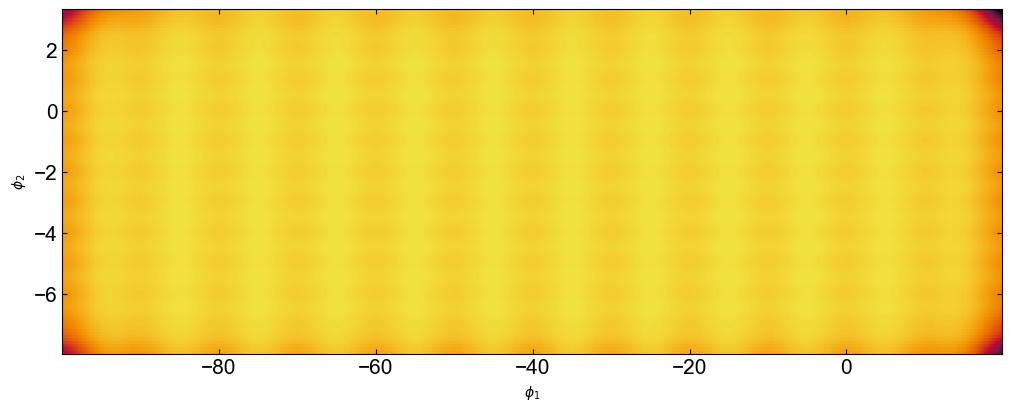

In [54]:
offtrack_init = OffModel(offtrack_init_p)
_ = offtrack_init.plot_model_projections(grid_coord_names=[('phi1', 'phi2')])

In [94]:
(stream_opt.phi1_lim[1] - stream_opt.phi1_lim[0]) /10

11.999997718959325

In [96]:
11*12

132

In [98]:
30*12

360

In [95]:
stream_opt.coord_bounds

{'phi1': (-99.99999968177843, 19.999977507814812),
 'phi2': (-7.970665258306633, 3.3488445561550395),
 'pm1': (-15.099955792705842, -4.636272829387963),
 'pm2': (-5.417437266355175, 1.929407661299365)}

# Mixture of all components

In [86]:
full_Components = [StrModel, BkgModel, OffModel]
full_mix_params0 = {
    "stream": mix_opt_pars['stream'],
    "background": mix_opt_pars['background'],
    "offtrack": offtrack_init_p,
}

In [87]:
tied_params = [
    (("offtrack", "pm1"), ("stream", "pm1")),
    (("offtrack", "pm2"), ("stream", "pm2")),
]
full_mix_init = StreamMixtureModel(
    full_mix_params0, full_Components, tied_params=tied_params
)

In [99]:
full_mix_params0['stream']

{'ln_N': Array(7.35574179, dtype=float64),
 'phi1': {'zs': Array([-5.13919105, -5.38621005, -5.30854442, -5.23893543, -5.79836357,
         -2.86547057,  0.16875586, -1.99397341, -0.27341397, -1.21650103,
         -3.36131496,  0.46679178, -2.20248451,  0.95596233,  1.47017071,
         -5.09870402,  0.83060753, -0.81018739,  1.24093584,  1.28828028,
         -7.79463892, -8.        ,  0.63092888,  1.8033034 , -7.38515702,
         -3.49399294,  2.77535689, -8.        , -8.        ,  4.41819881,
          7.32461167,  3.03437765], dtype=float64)},
 'phi2': {'ln_std': Array([-0.83688945, -0.87106046, -0.80357363, -0.7291631 , -1.11773471,
         -1.32681447, -0.80527048, -0.81954905, -1.78510734, -1.73624187,
         -1.56901926, -1.53464121, -1.55492508], dtype=float64),
  'mean': Array([-3.07777765, -3.0190492 , -2.07525437, -1.16341538, -0.58129928,
         -0.04302355,  0.26344024,  0.24885012, -0.03071162, -0.30366318,
         -1.30205623, -1.80117046, -3.05990653], dtype=floa

In [88]:
full_mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data,
    Components=full_Components,
    tied_params=tied_params,
    init_params=full_mix_params0,
    use_bounds=True,
)

# full_mix_opt_pars, info = optimize_mixture(StreamMixtureModel, data=run_data,
#                                       init_params=full_mix_params0, Components=full_Components,
#                                       use_bounds=True)

full_mix_opt = StreamMixtureModel(full_mix_opt_pars, Components=full_Components)
info

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (439,)  and requested shape (491,)

In [165]:
import pickle

In [166]:
with open('../data/full_model_opt_params.pkl', 'wb') as output_file2:
    pickle.dump(full_mix_opt_pars, output_file2)

NameError: name 'full_mix_opt_pars' is not defined

In [172]:
# with open('../data/full_model_optimization.pkl', 'rb') as input_file:
#     testing1 = pickle.load(input_file)

with open('../data/full_model_opt_params_small_sep.pkl', 'rb') as input_file:
    full_mix_opt_pars = pickle.load(input_file)

In [47]:
# if optimization fails, run again with initialization from the end of the last run

# full_mix_params1 = full_mix_opt_pars

# full_mix_opt_pars1, info1 = StreamMixtureModel.optimize(
#     data=run_data,
#     Components=full_Components,
#     #tied_params=tied_params,
#     init_params=full_mix_params1,
#     use_bounds=True,
# )
# full_mix_opt1 = StreamMixtureModel(full_mix_opt_pars1, Components=full_Components)
# info1

In [174]:
import copy
tmp_pars = copy.deepcopy(full_mix_opt_pars['offtrack'])
tmp_pars['pm1'] = full_mix_opt_pars['stream']['pm1'].copy()
tmp_pars['pm2'] = full_mix_opt_pars['stream']['pm2'].copy()
tmp = OffTrackModel(tmp_pars)
tmp.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], label=False, 
    pcolormesh_kwargs=dict(vmin=0, vmax=1, cmap='cmr.ember_r')
)

ValueError: No default grid for phi1, so you must specify it via the `grids` argument

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

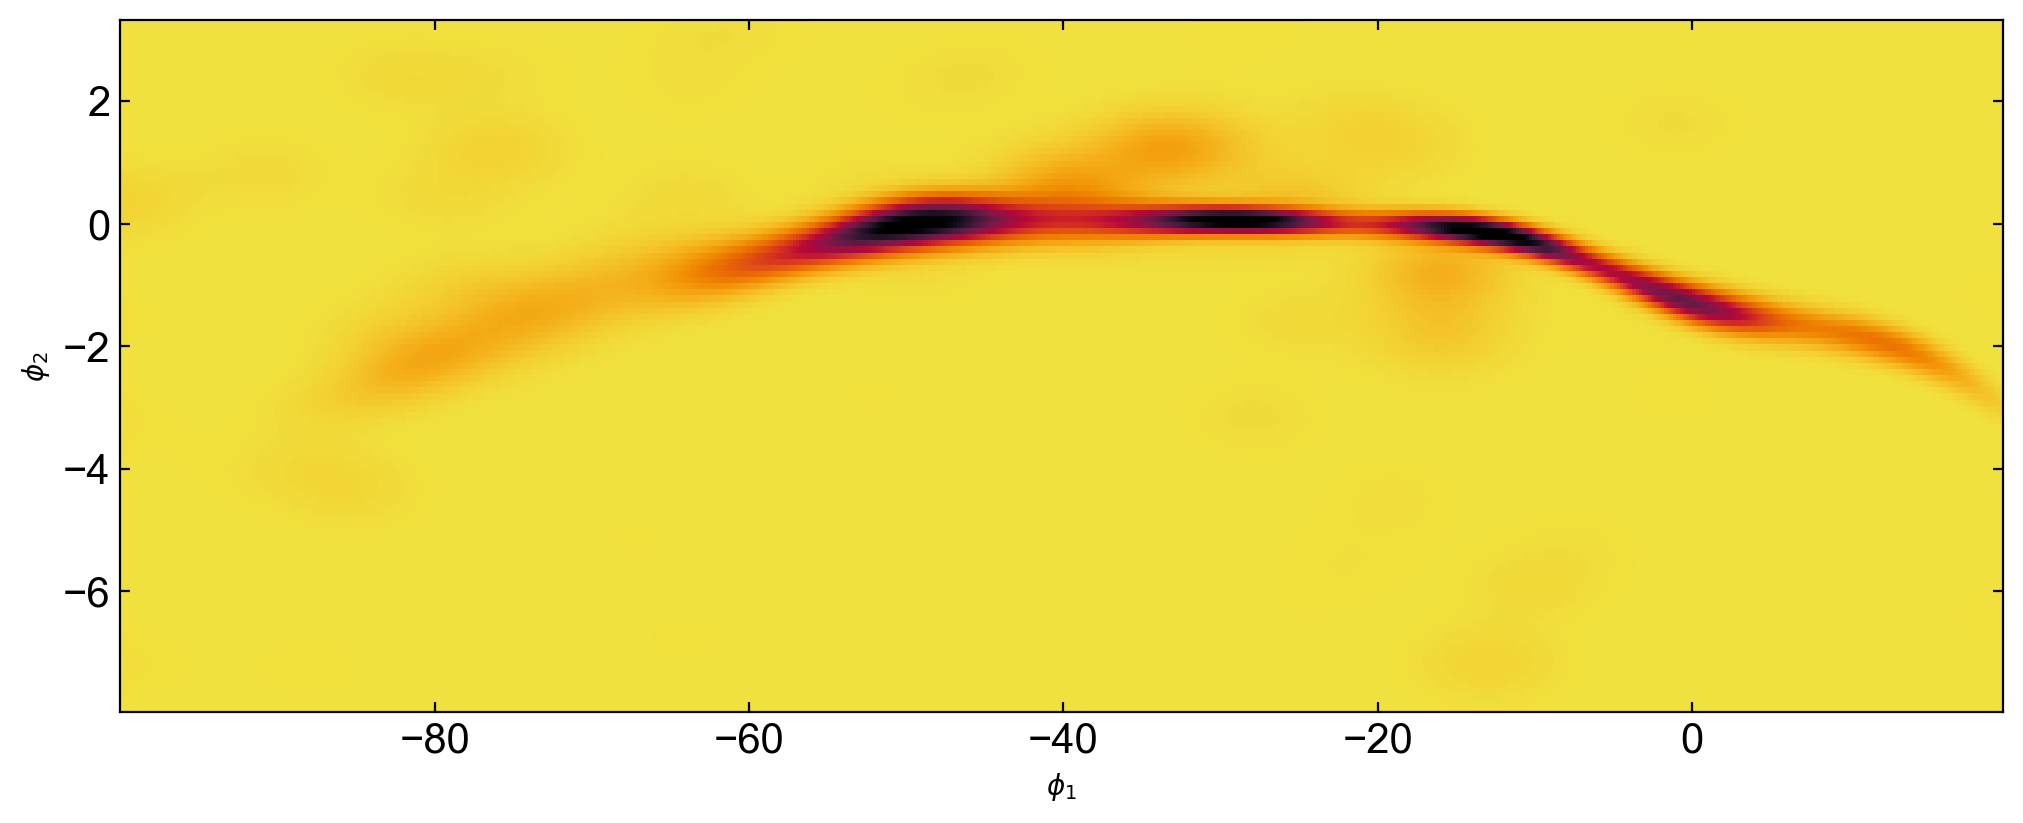

In [76]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[StreamDensModel, OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=1, cmap='cmr.ember_r')
)

In [52]:
full_mix_opt.components

In [62]:
stream_comp, bkg_comp, offtrack_comp = full_mix_opt.components[0], full_mix_opt.components[1], full_mix_opt.components[2]
stream_ll = -np.log(stream_comp.get_N()) + stream_comp.ln_number_density(run_data)
bkg_ll = -np.log(bkg_comp.get_N()) + bkg_comp.ln_number_density(run_data)
offtrack_ll = -np.log(offtrack_comp.get_N()) + offtrack_comp.ln_number_density(run_data)

#one way
fg_ll = np.logaddexp(stream_ll, offtrack_ll)

#another way
# fg_comps = full_mix_nobkg_opt.components
# fg_ll_ = -np.log(fg_comps[0].get_N() + fg_comps[1].get_N()) + full_mix_nobkg_opt.ln_number_density(run_data)

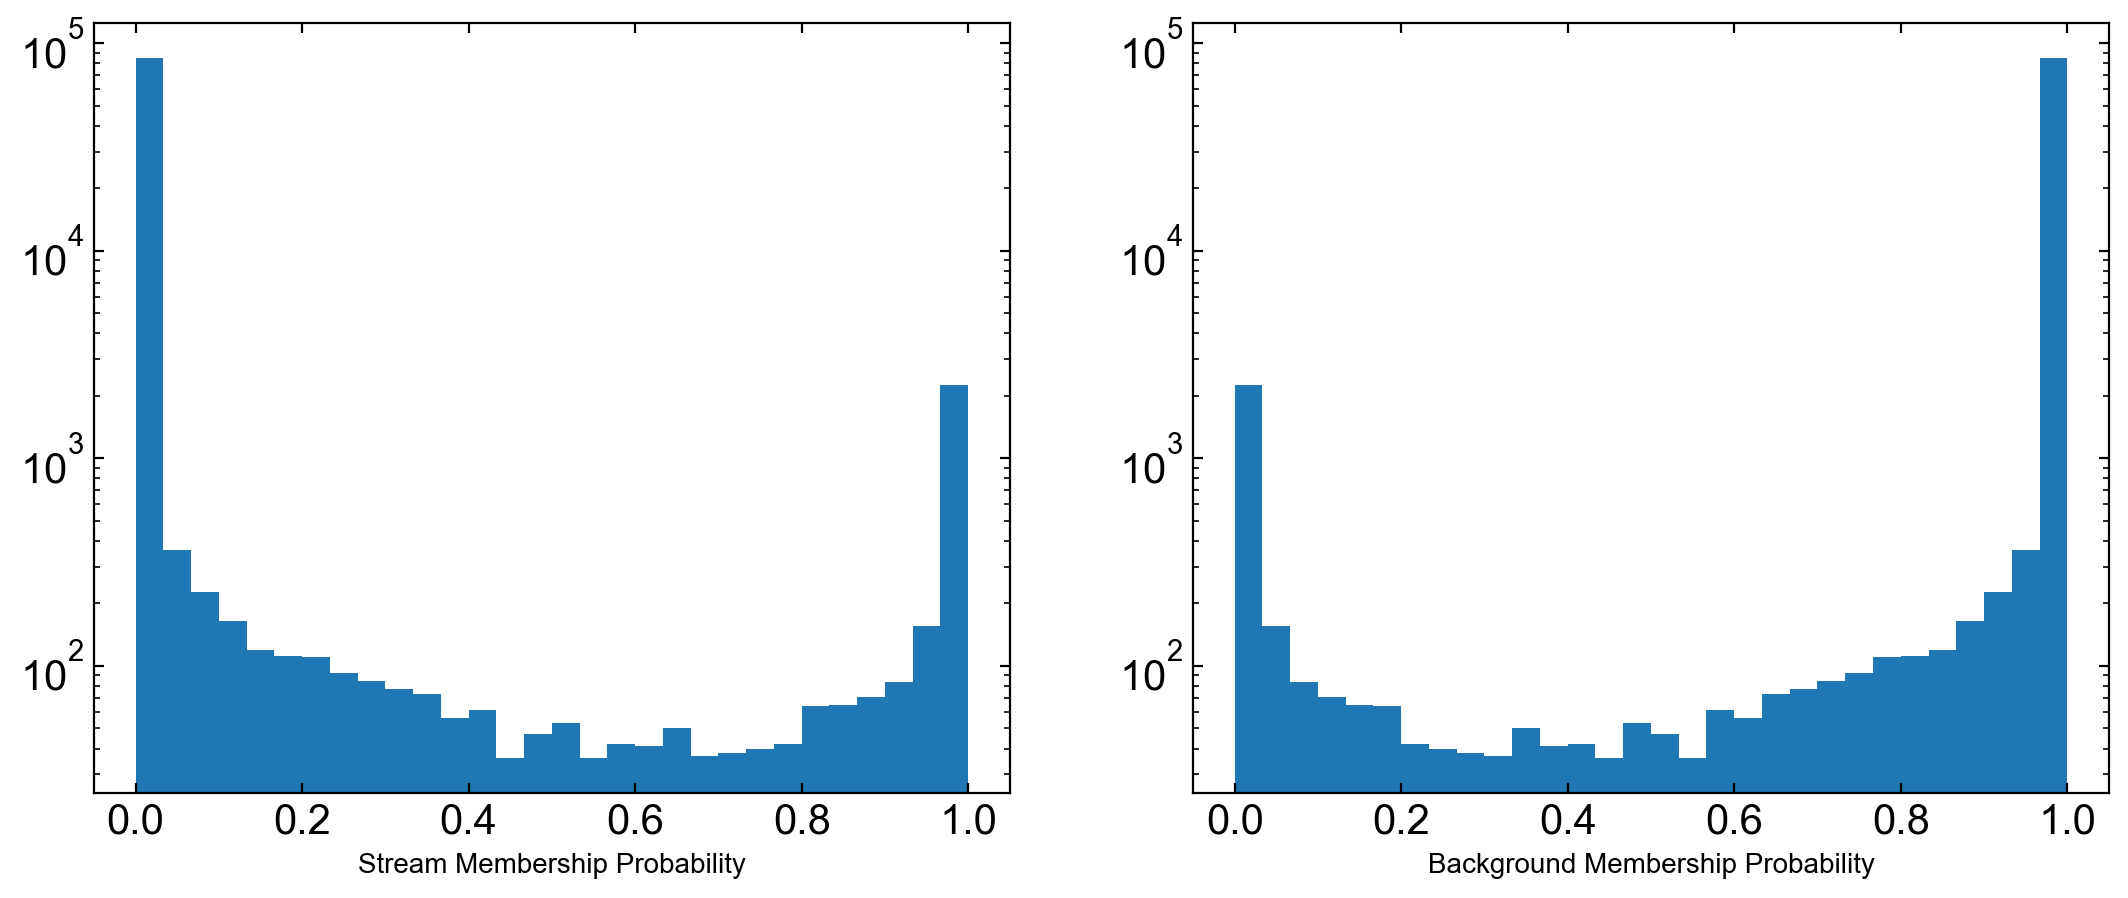

In [63]:
final_memb_prob = np.exp(fg_ll - np.logaddexp(fg_ll,bkg_ll)) #update for offtrack included
bkg_prob = np.exp(bkg_ll - np.logaddexp(fg_ll,bkg_ll))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5))
ax1.hist(final_memb_prob, bins=30)
ax1.set_yscale('log')
ax1.set_xlabel('Stream Membership Probability')

ax2.hist(bkg_prob, bins=30)
ax2.set_xlabel('Background Membership Probability')
ax2.set_yscale('log')
plt.show()

In [78]:
(final_memb_prob > 0.99).sum()

1951

In [66]:
# for the plotting, but takes a minute, so have it in a differnet cell
_grids, ln_dens = full_mix_opt.evaluate_on_2d_grids()

KeyError: 'phi1'

Text(0, 0.5, '$\\phi_2$')

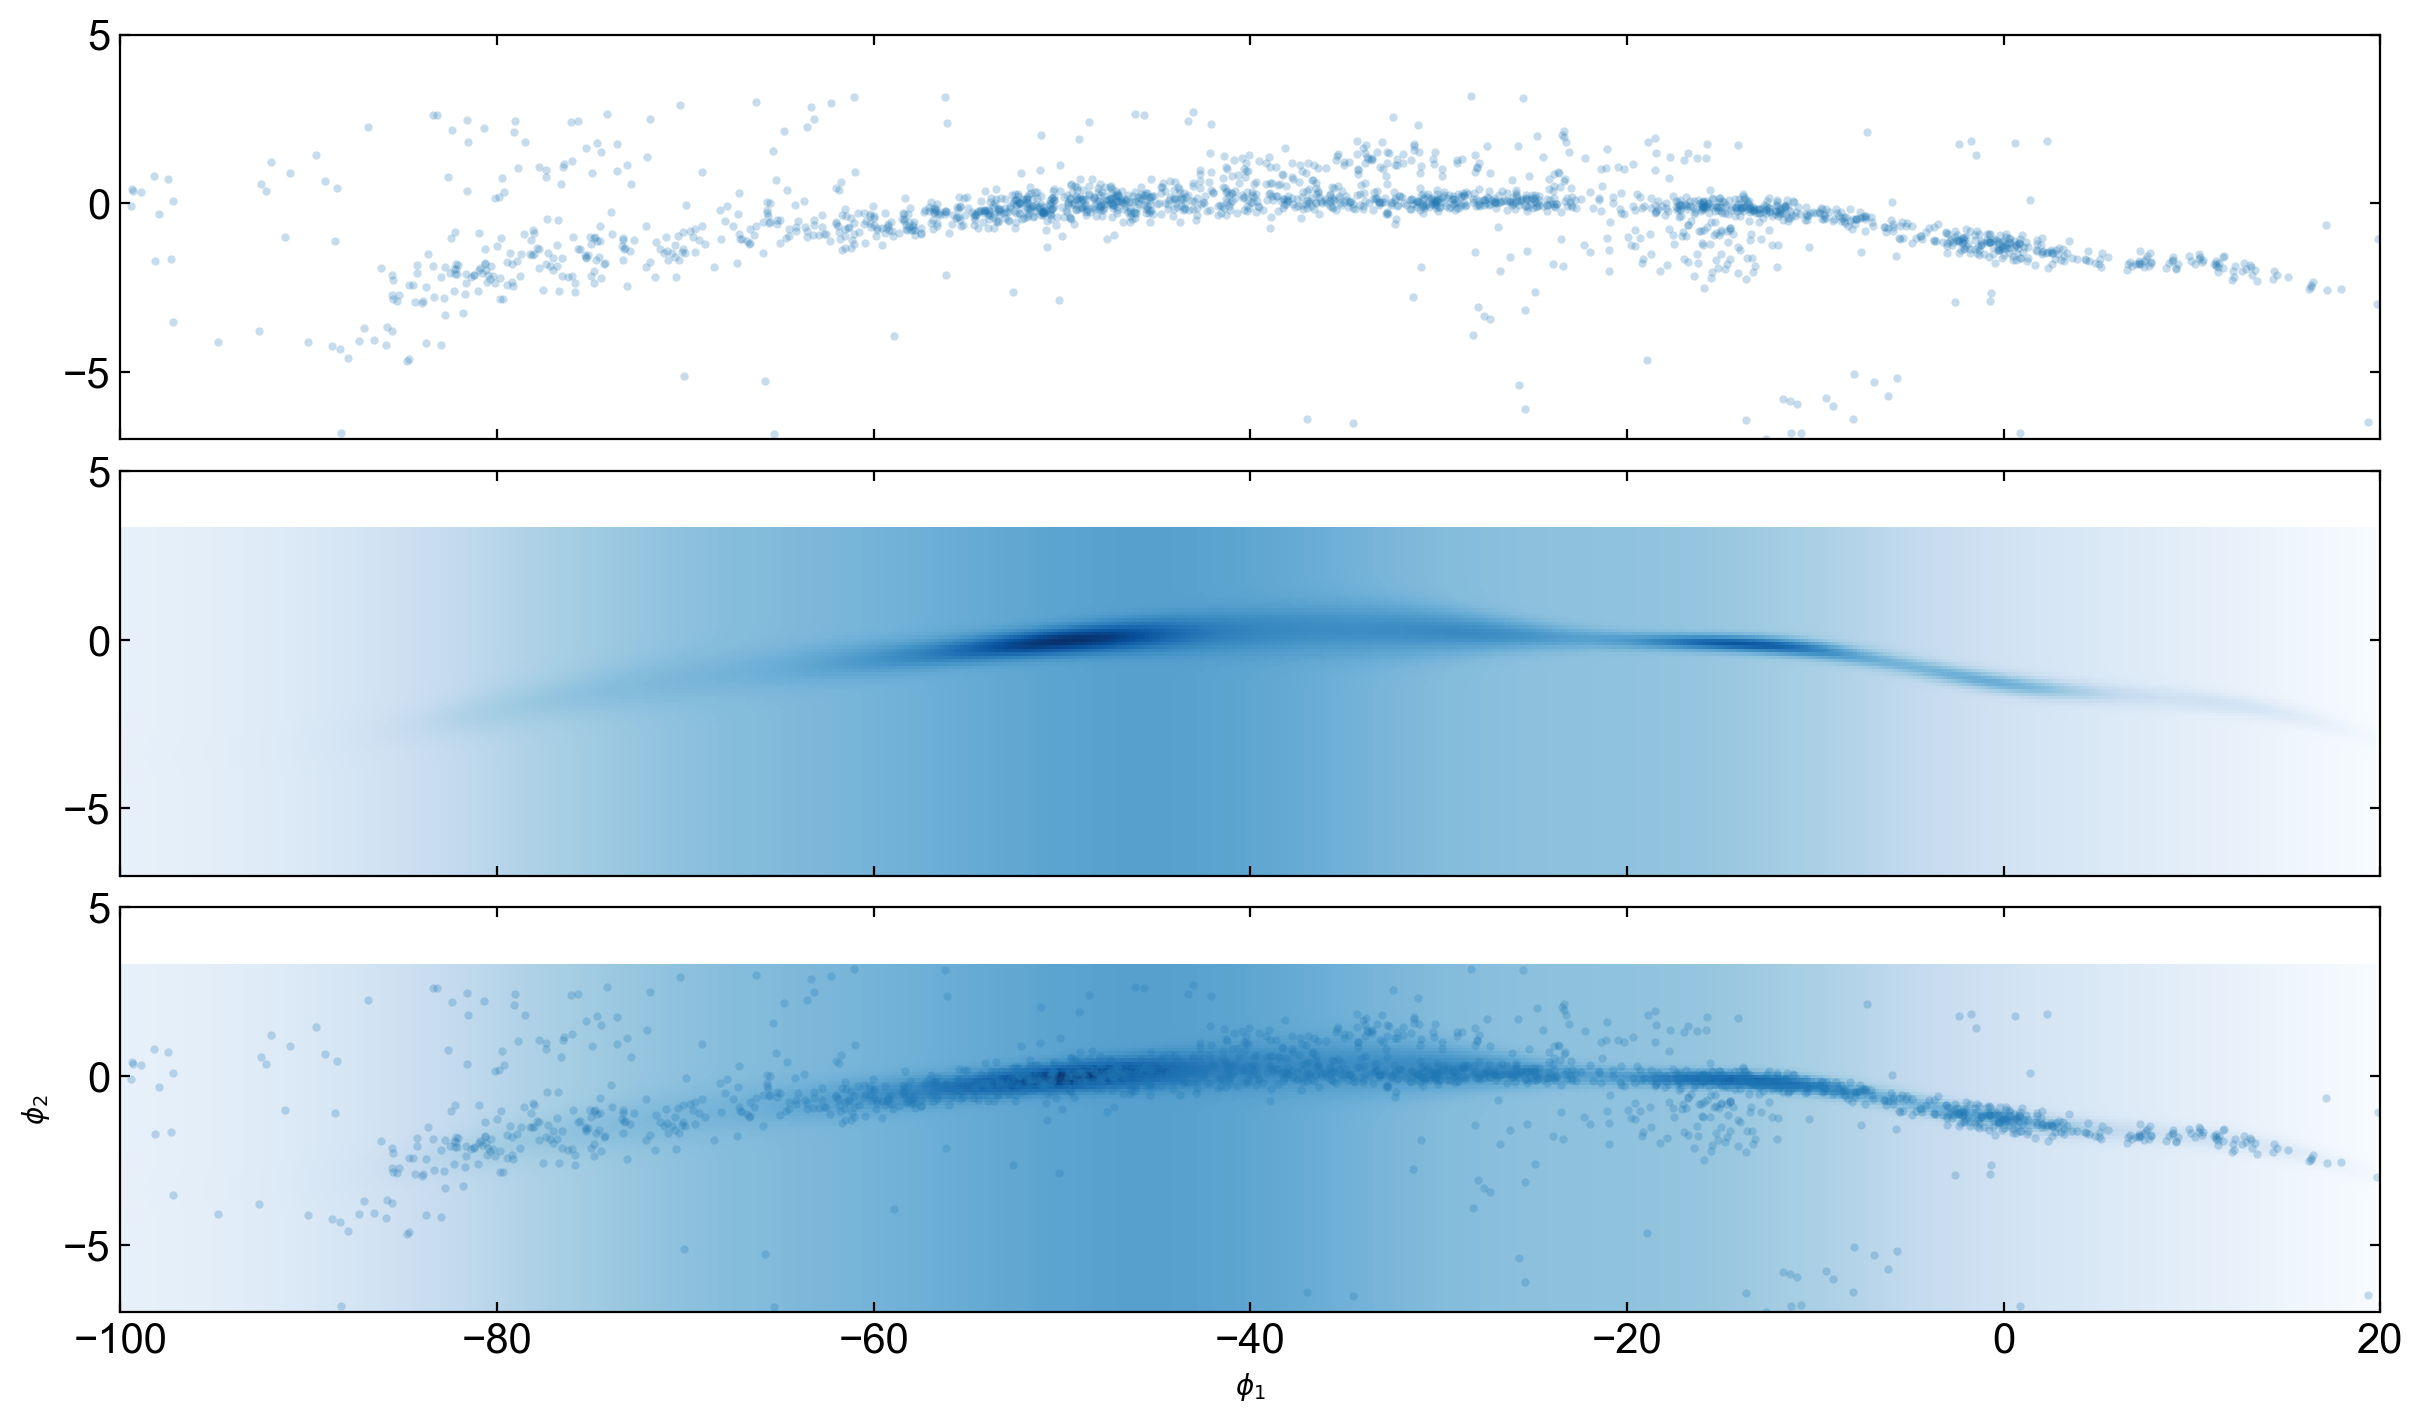

In [77]:
threshold = (final_memb_prob>0.99)

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)
for ax in [axes[0], axes[2]]:
    ax.plot(
        run_data['phi1'][threshold],
        run_data['phi2'][threshold],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

KeyError: 'phi1'

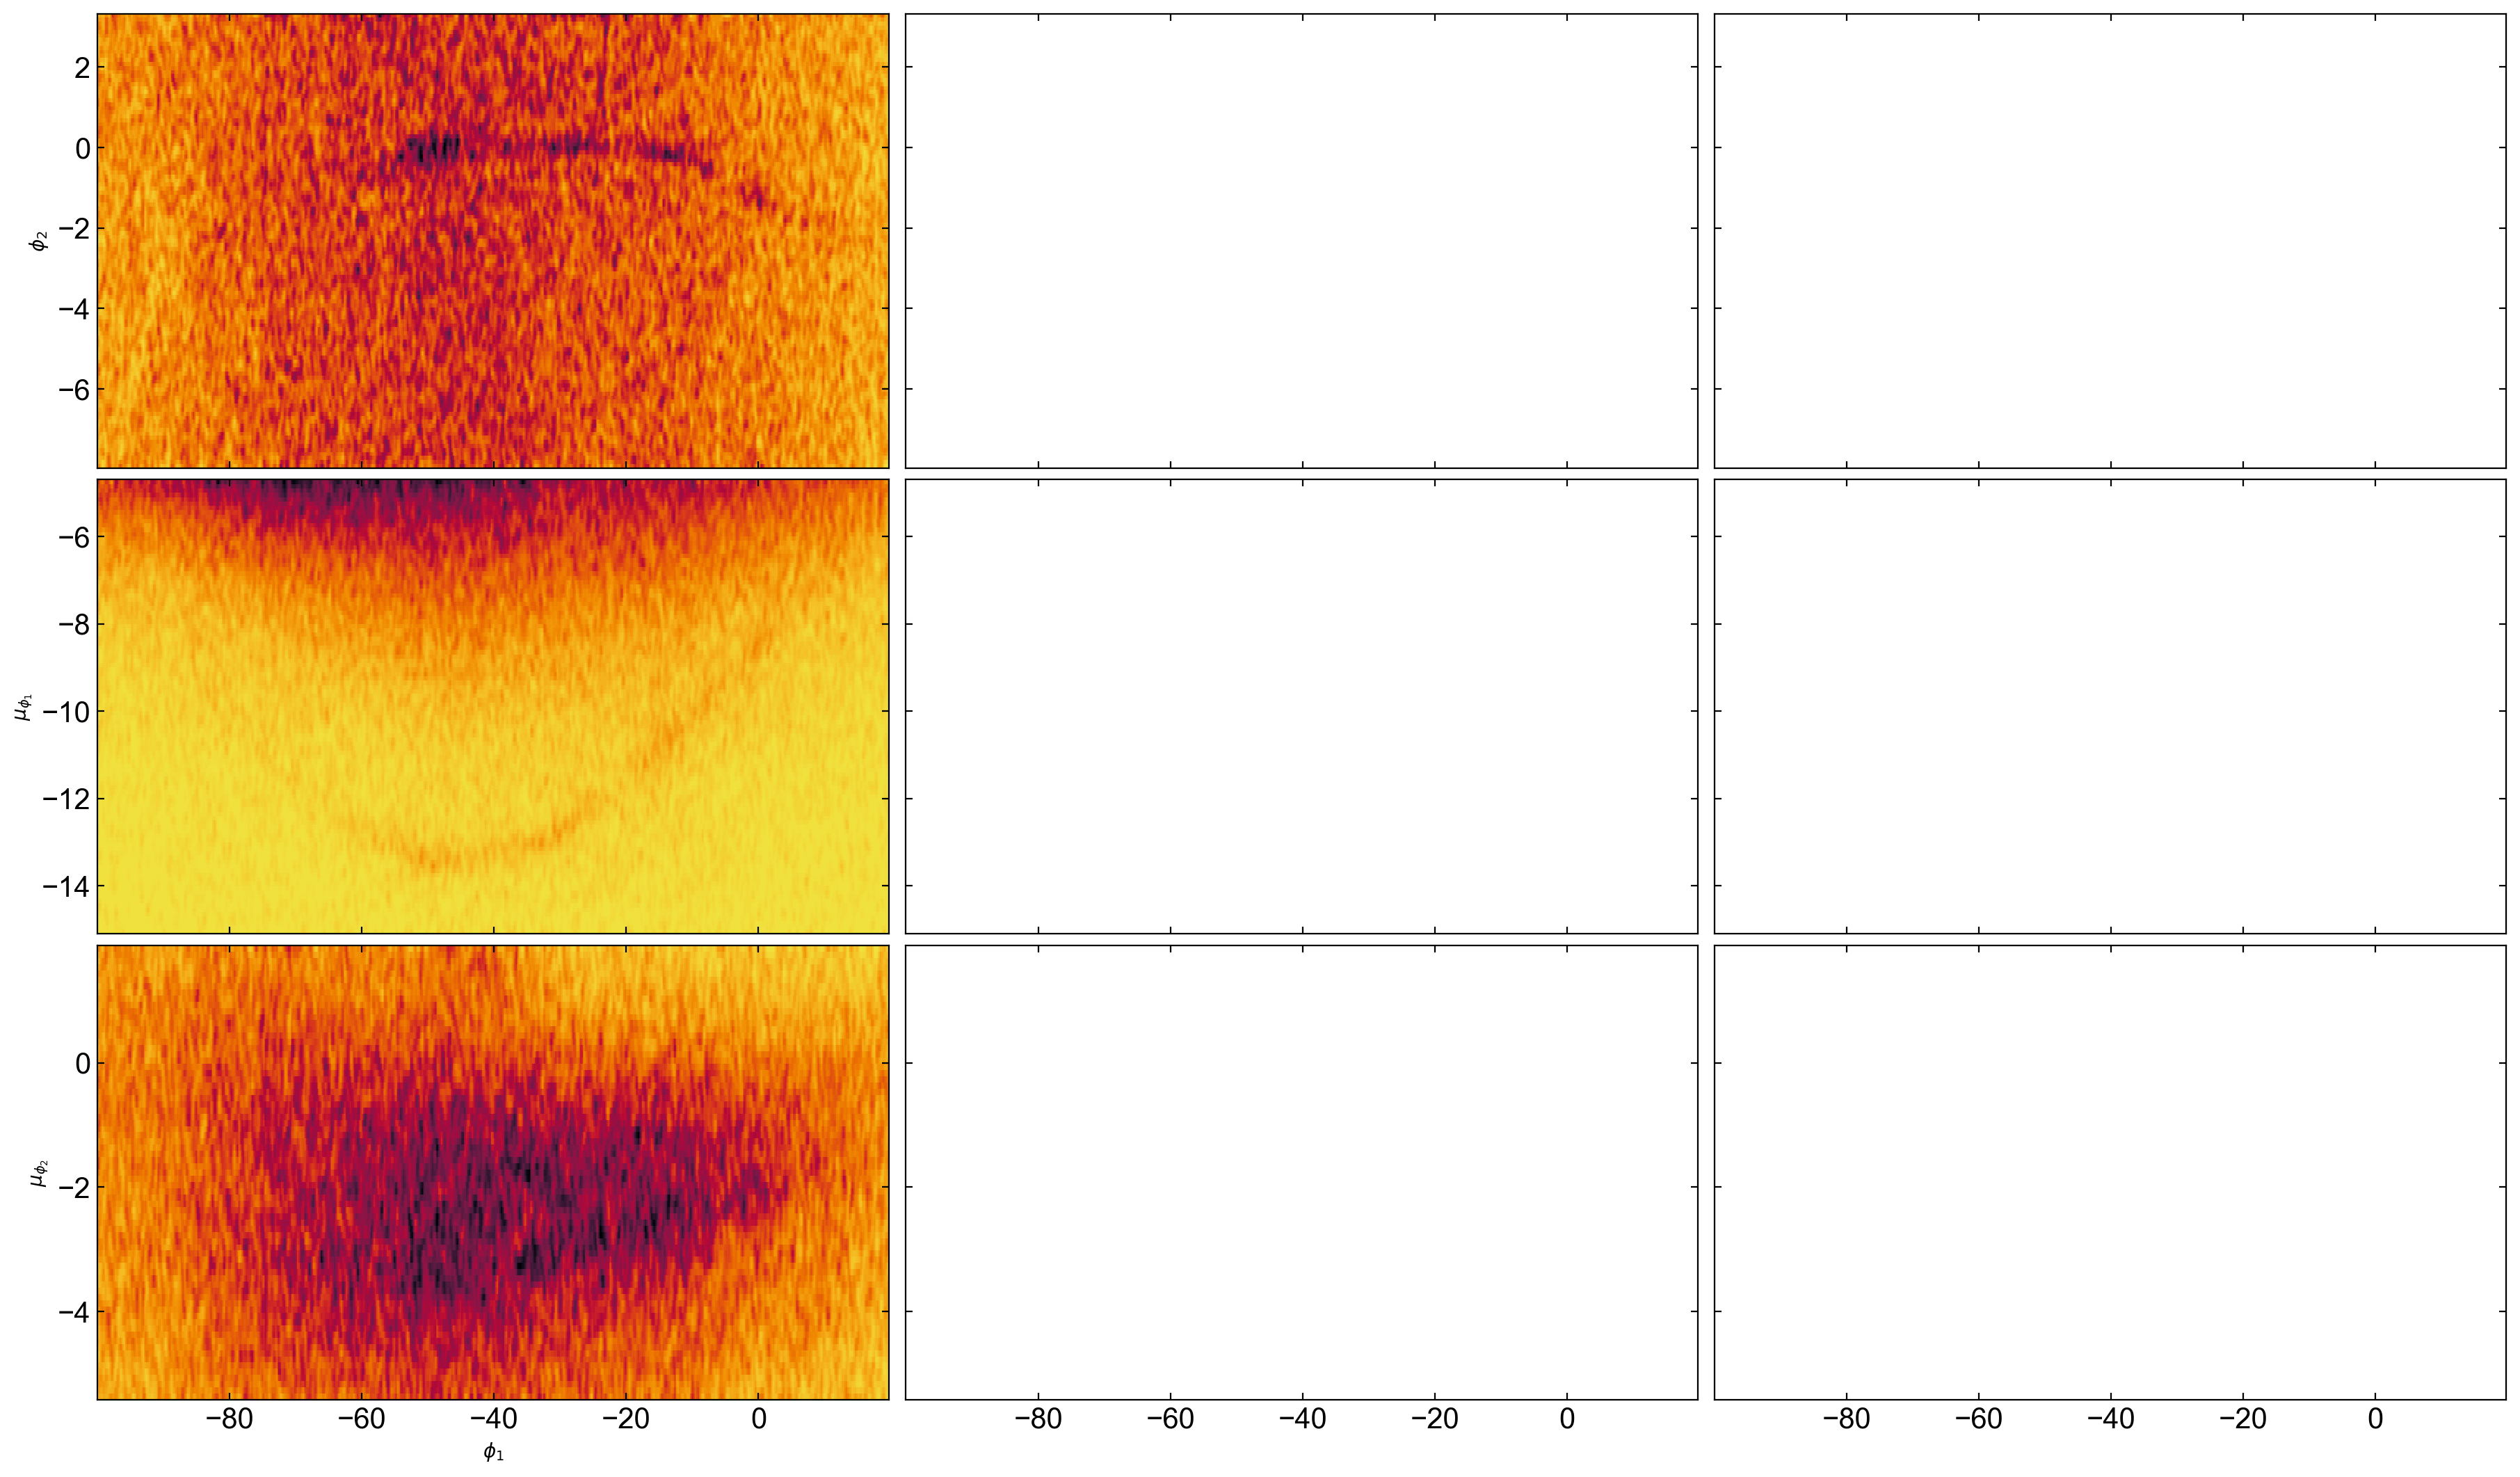

In [79]:
fig, axes = plt.subplots(
    len(full_mix_nobkg_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(full_mix_nobkg_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)
full_mix_nobkg_opt.plot_model_projections(axes=axes[:, 1])
full_mix_nobkg_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

KeyError: 'phi1'

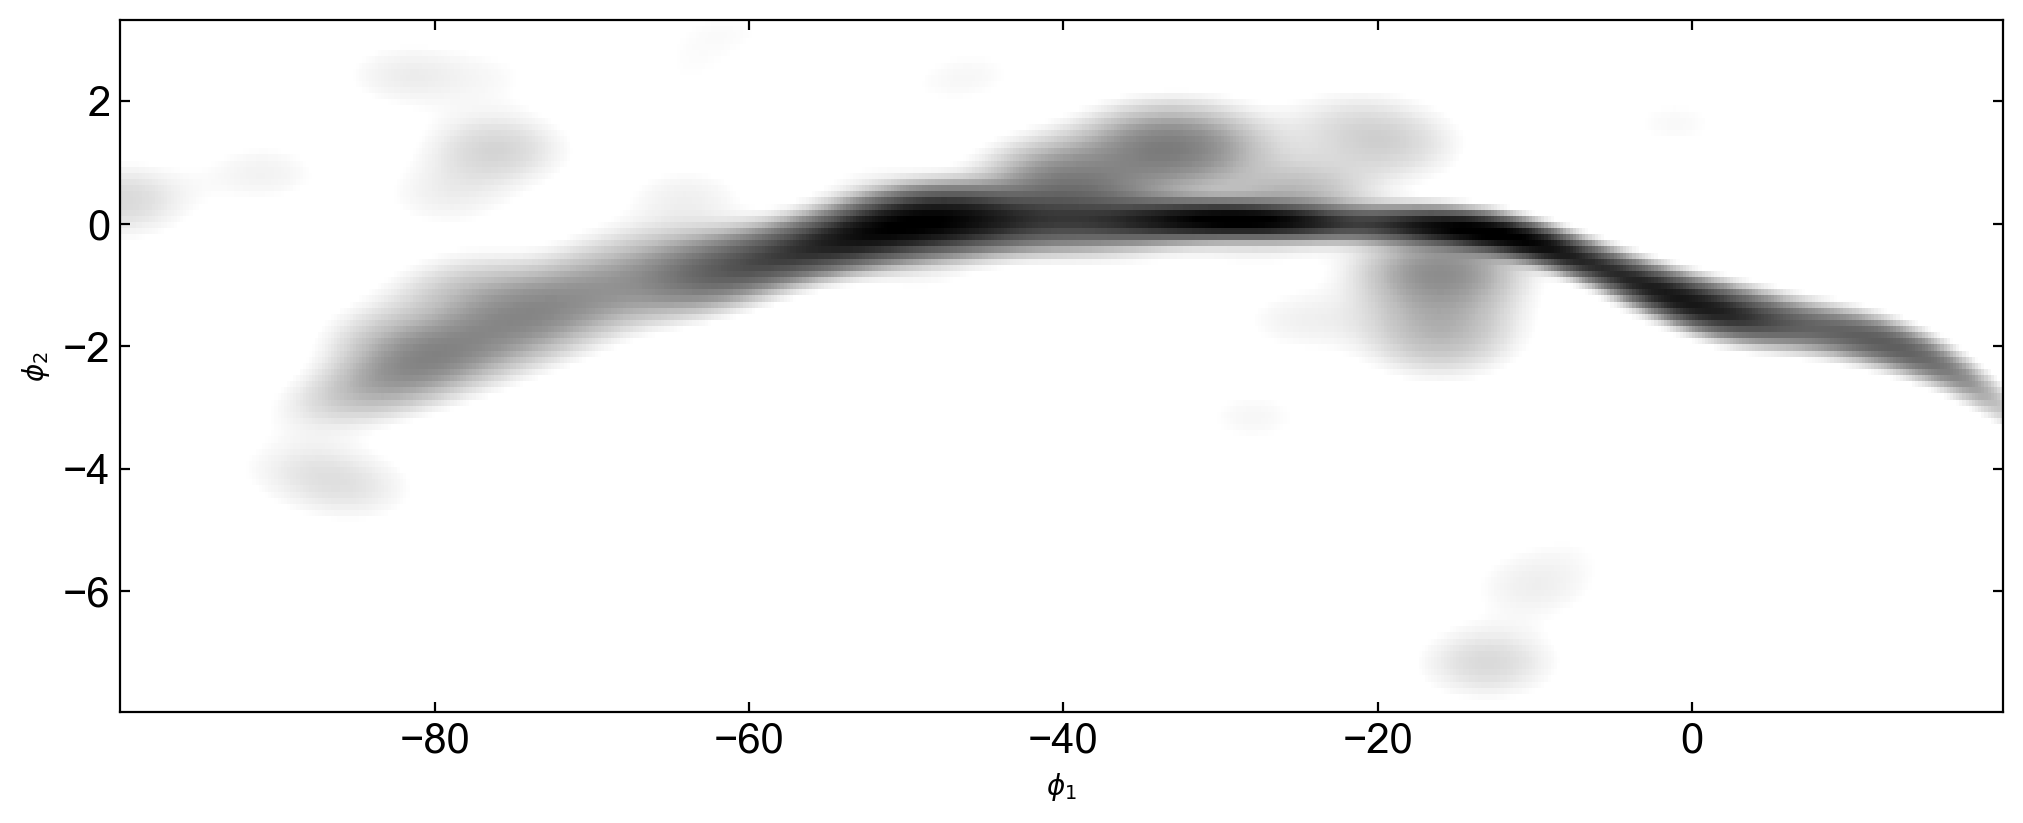

In [81]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[StreamDensModel, OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1), cmap='Greys')
)

full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "pm1")], pcolormesh_kwargs=dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1), cmap='Greys')
)

full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "pm2")], pcolormesh_kwargs=dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1), cmap='Greys')
)

In [82]:
full_mix_opt.spar_steps

AttributeError: 'StreamMixtureModel' object has no attribute 'spar_steps'

KeyError: 'phi1'

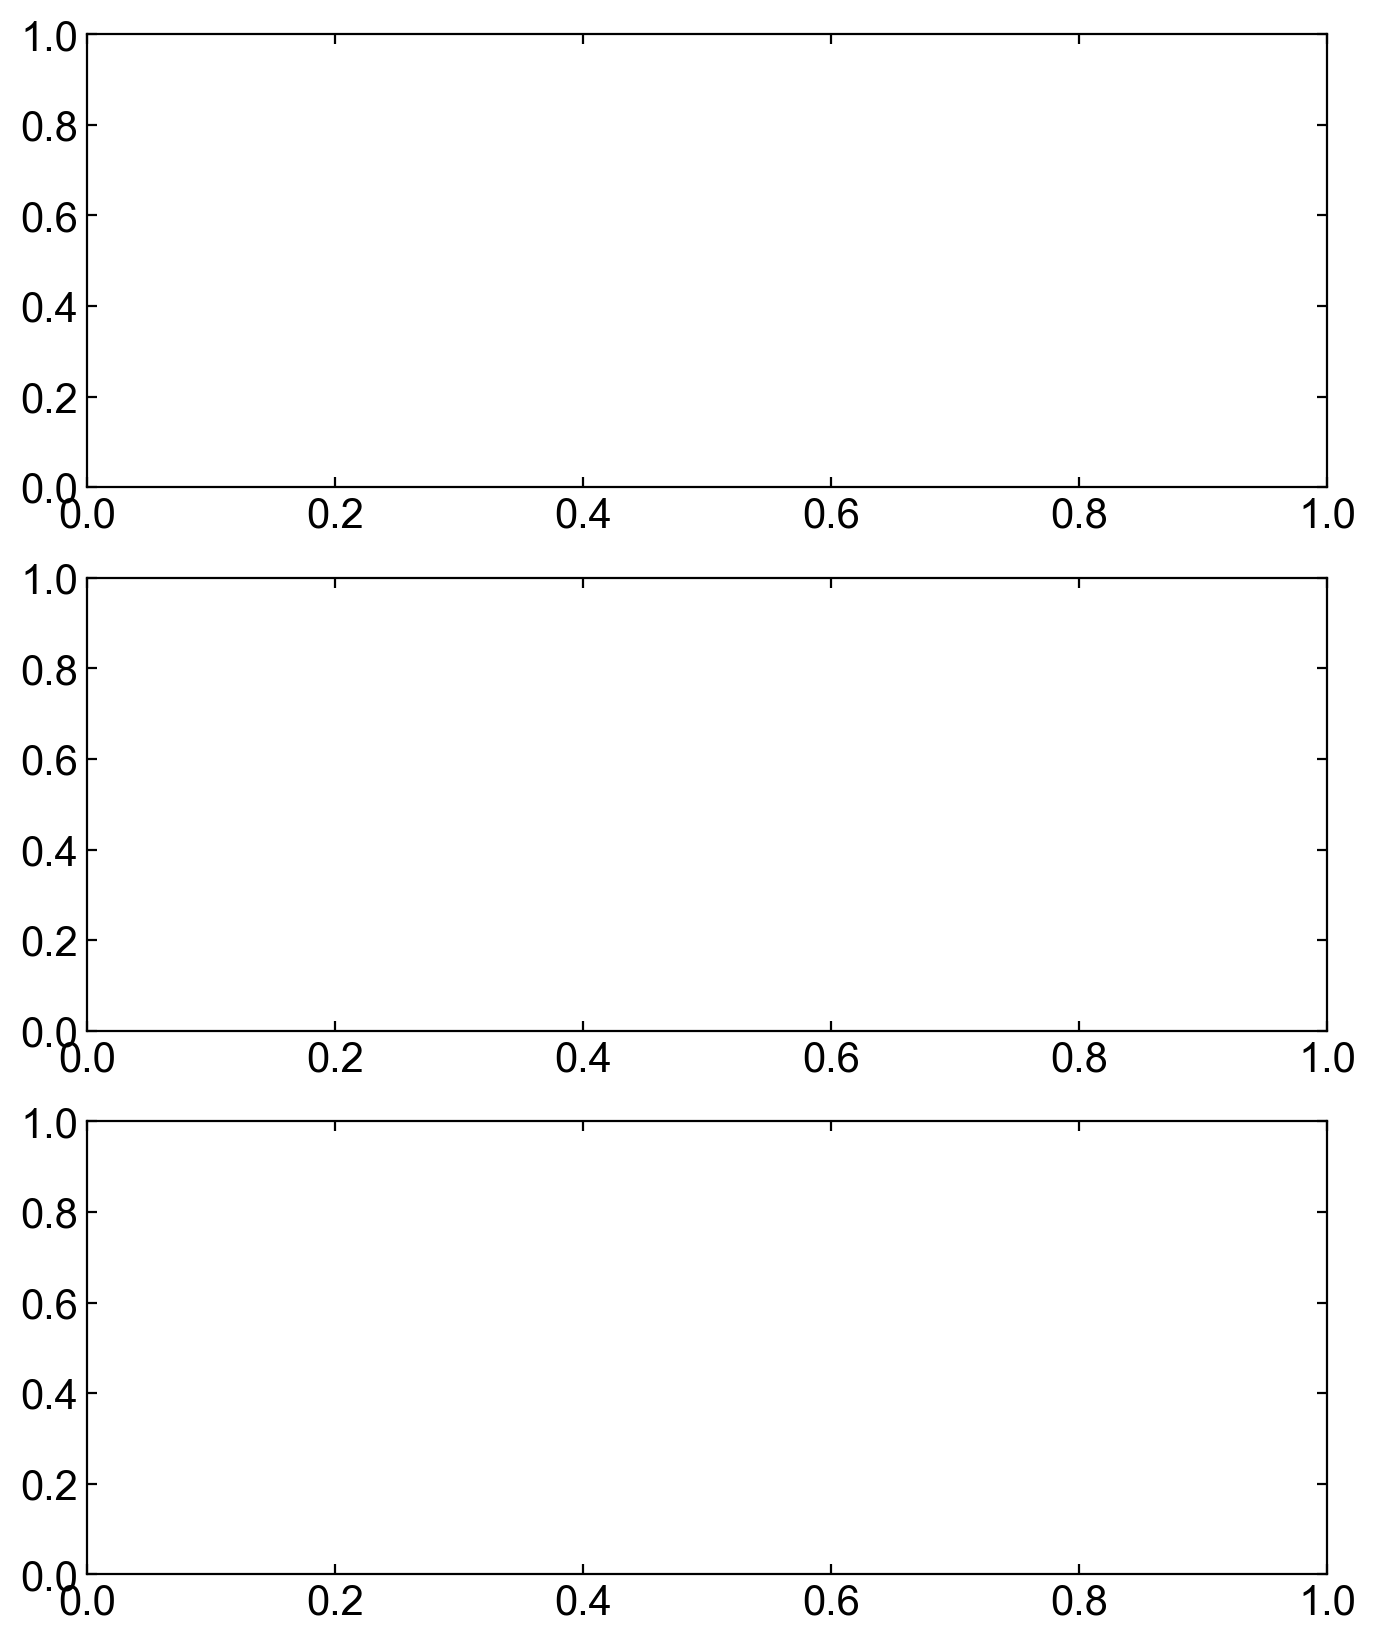

In [102]:
fig, axs = plt.subplots(3,1,figsize=(8,10))
full_mix_nobkg_opt.plot_model_projections(pcolormesh_kwargs=dict(vmin=0, vmax=0.5), axes=axs)

KeyError: 'phi1'

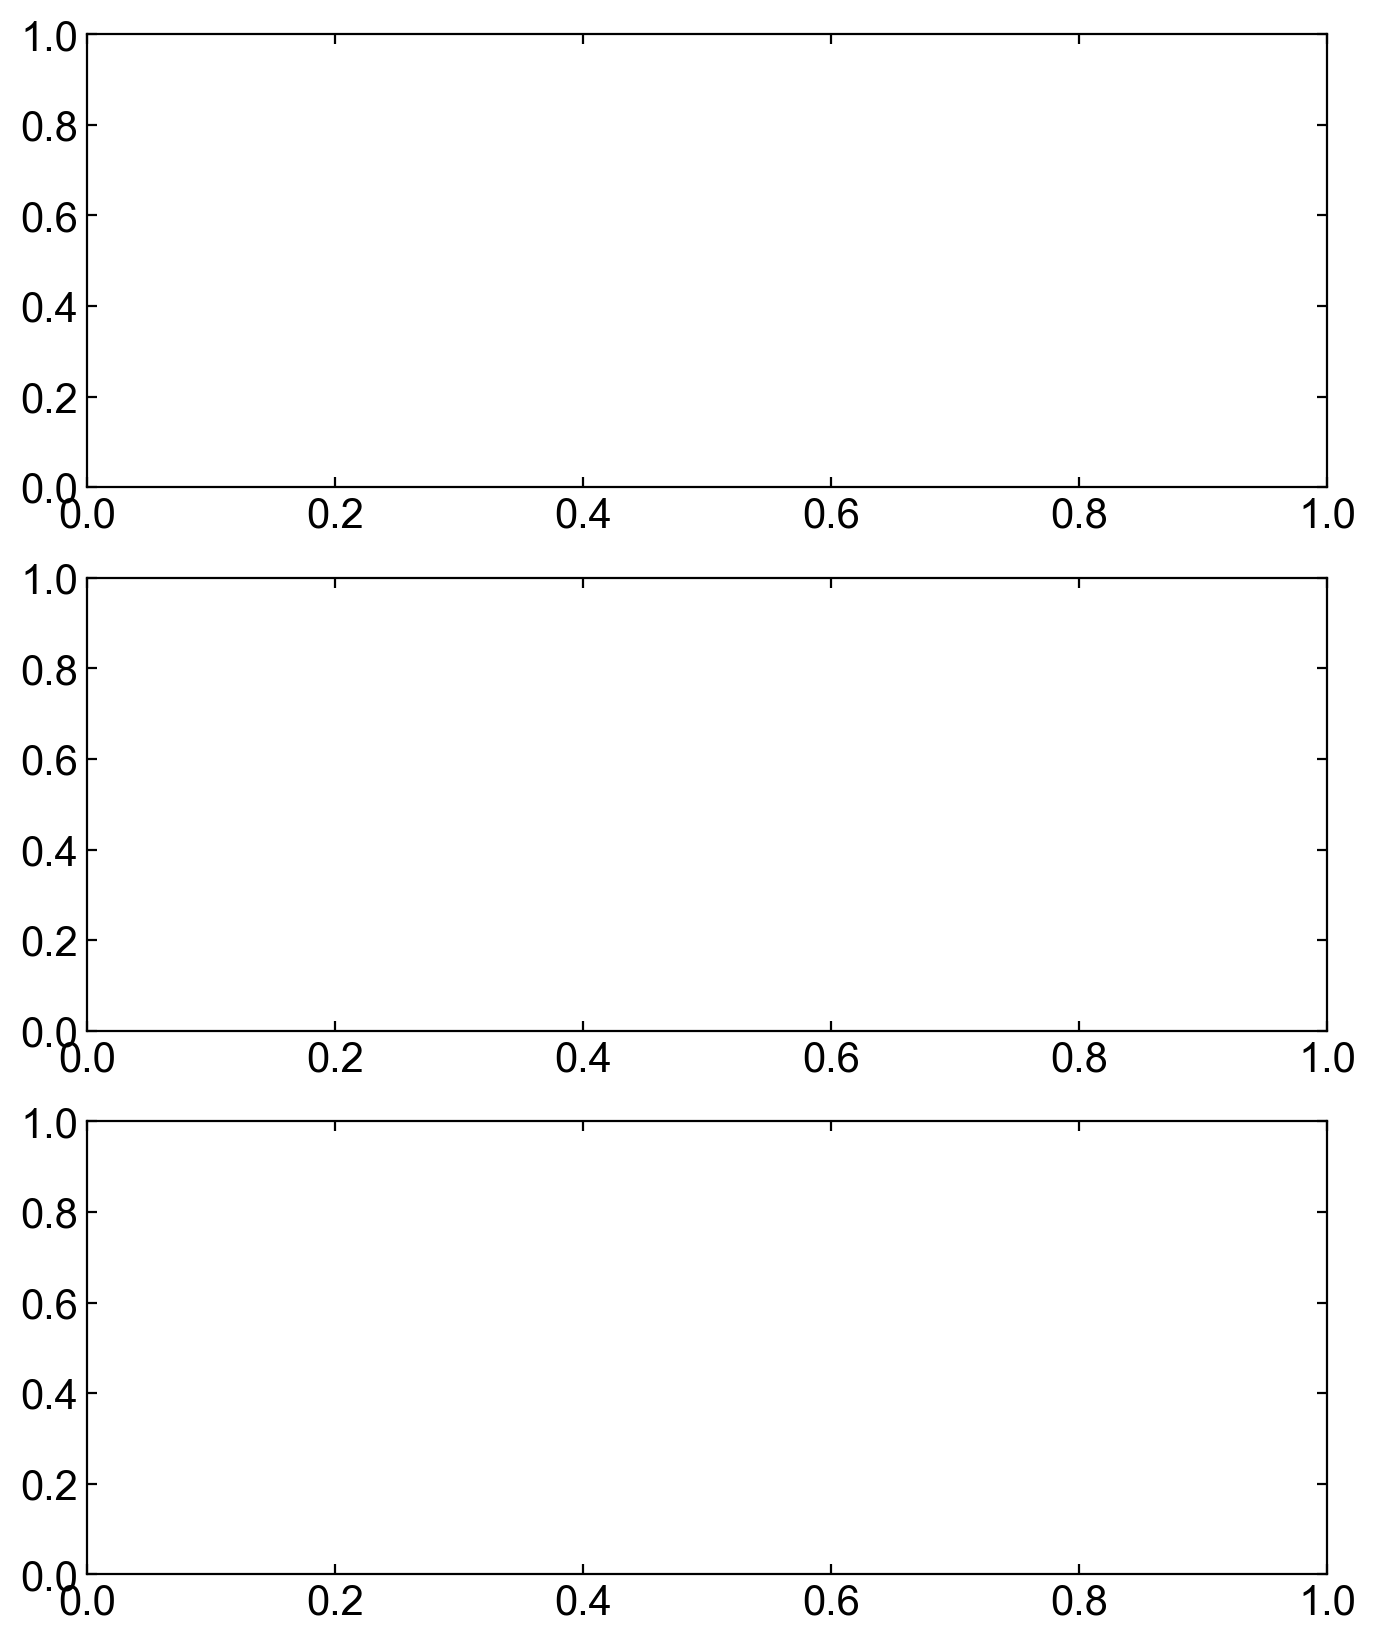

In [96]:
fig, axs = plt.subplots(3,1,figsize=(8,10))
full_mix_opt.plot_model_projections(pcolormesh_kwargs=dict(vmin=0, vmax=0.5), axes=axs)

TODO: how to plot projections for components where the x coord is in a joint, like OffTrack?

KeyError: 'phi1'

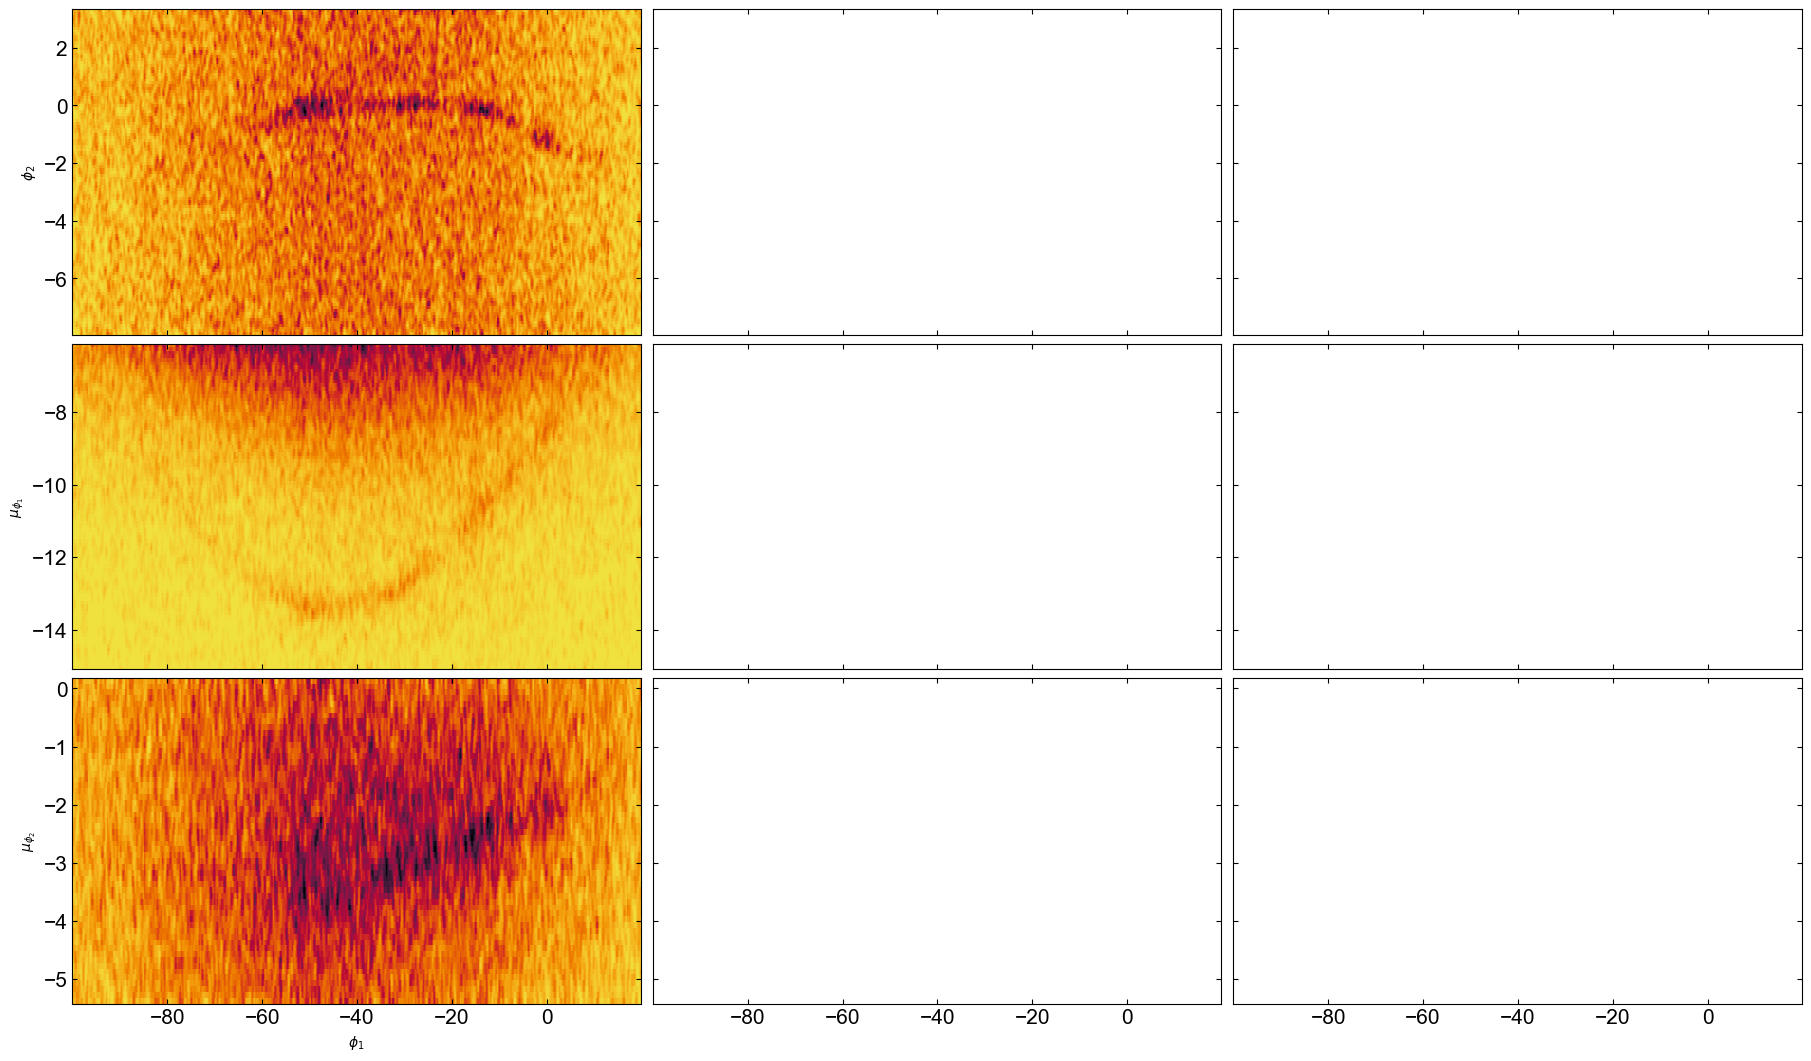

In [81]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)


axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)
full_mix_opt1.plot_model_projections(axes=axes[:, 1])
full_mix_opt1.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")